# Dynap-SE1

DynapSE1 board consists of 4 chips, each having 4 cores inside. Each core harbors 64 Adaptive Exponential Integrate-and-Fire (AdExpIF) neurons, each with 64 fan-in. That means each AdExpIF neuron has a potential of 64 synapses to receive incoming connections of its presynaptic neurons. There are 4 types of synapses: AMPA, NMDA, GABA_A, and GABA_B.

Each core holds a `parameter group` to store the neuronal and synaptic parameters for its 64 neurons and their incoming synapses. The neurons in the same core share the same parameter values, including time constants, refractory periods, and weights. Therefore, different connection strengths between neurons can only be achieved by setting the same connection multiple times.

For spike input, 1024 spike generators, or virtual neurons, are available implemented on the FPGA. Each of the spike generators can be used as a Poisson spike generator or a normal FPGA spike generator. The overview of the architecture is summarized in figure below.

![architecture](images/architecture.png)

The connectivity and information delivery between neurons a two-stage tag-based routing scheme [1] is used. It’s a novel routing methodology to handle the asynchronous address-event traffic. In this tutorial detailed explanation of the routing mechanism is omitted. The simulator can be used by defining a simple weight matrices.

![network](./images/network_v2.png)

[1] S. Moradi, N. Qiao, F. Stefanini, and G. Indiveri, “A scalable multicore architecture with heterogeneous memory structures for dynamic neuromorphic asynchronous processors (dynaps),” IEEE Transactions on Biomedical Circuits and Systems, vol. 12, no. 1, pp. 106–122, 2018.

In [1]:
from rockpool import (
    TSEvent,
    TSContinuous,
)

from rockpool.devices.dynapse import (
    DynapSE1Jax,
    DynapSE1NeuronSynapseJax,
    DynapSE1Layout,
    DPIParameters,
    SynapseParameters,
    FeedbackParameters,
    MembraneParameters,
    AHPParameters,
    NMDAParameters,
    AMPAParameters,
    GABAAParameters,
    GABABParameters,
    DynapSE1SimulationConfiguration,
    random_spike_train,
    step_pwl,
    Figure,
)

import numpy as np
import jax.numpy as jnp

# - Configuration of plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/home/ugurc/anaconda3/envs/synsense/lib/python3.8/site-packages/samna
finished bindings
No module named 'netgen' 
Router cannot extract the virtual connections from the network generator object!


## Global parameters

Above global parameters are defined to be used in multiple object creation.

In [2]:
Nin = 3 # number of neurons
Nrec = 5
# Nout = 2

dt = 1e-3 # simulation time resolution
T = 1 # duration in seconds
rate = 50 # input firing rate in Hertz

## Weight Initialization

One can define an input weight matrix and an output weight matrix for initialization. The weight matrix stores the number of synapses between neurons.

### Virtual(External Input) -> Real(In-Device)

| GABA_B 	| GABA_A   	| NMDA     	| AMPA     	|
|--------	|----------	|----------	|----------	|
|        	| v3 -> n4 	| v1 -> n2 	| v0 -> n0 	|
|        	|          	| v1 -> n3 	| v0 -> n1 	|
|        	|          	| v1 -> n4 	| v0 -> n4 	|

### Real(In-Device) -> Real(In-Device)

| GABA_B   	| GABA_A   	| NMDA     	| AMPA     	|
|----------	|----------	|----------	|----------	|
| n2 -> n0 	| n0 -> n4 	| n4 -> n4 	| n0 -> n1 	|
| n2 -> n0 	|          	|          	| n2 -> n3 	|
|          	|          	|          	| n3 -> n2 	|



In [3]:
w_in = np.array(
       #  Gb Ga N  A
       [[[0, 0, 0, 1],  # pre = 0 (virtual) post = 0 (device)
         [0, 0, 0, 1],  #                   post = 1 (device)
         [0, 0, 0, 0],  #                   post = 2 (device)
         [0, 0, 0, 0],  #                   post = 3 (device)
         [0, 0, 0, 1]], #                   post = 4 (device)

        [[0, 0, 0, 0],  # pre = 1 (virtual)
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1]],

        [[0, 0, 0, 0],  # pre = 2 (virtual)
         [0, 0, 0, 0], 
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 1, 0, 0]]], dtype=np.uint8)

w_rec = np.array(
      #  Gb Ga N  A
       [[[0, 0, 0, 0],  # pre = 0 (device)  post = 0 (device)
         [0, 0, 0, 1],  #                   post = 1 (device)
         [0, 0, 0, 0],  #                   post = 2 (device)
         [0, 0, 0, 0],  #                   post = 3 (device)
         [0, 1, 0, 0]], #                   post = 4 (device)

        [[0, 0, 0, 0],  # pre = 1 (device)
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[2, 0, 0, 0],  # pre = 2 (device)
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],  # pre = 3 (device)
         [0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 1]],
       
        [[0, 0, 0, 0],  # pre = 4 (device)
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 1, 0]]], dtype=np.uint8)

In [4]:
# DynapSE1Jax?
modSE = DynapSE1Jax((Nin, Nrec), w_in=w_in, w_rec=w_rec, dt=dt)

## Input Spike Train

Generate an input spike train using utility functions provided `rockpool.devices.dynapse.utils.random_spike_train()` or `rockpool.devices.dynapse.utils.custom_spike_train()`

In [5]:
# random_spike_train?
input_ts = random_spike_train(
    duration=T,
    n_channels=Nin,
    rate=rate,
    dt=dt,
    name='Input Spike Train',
)

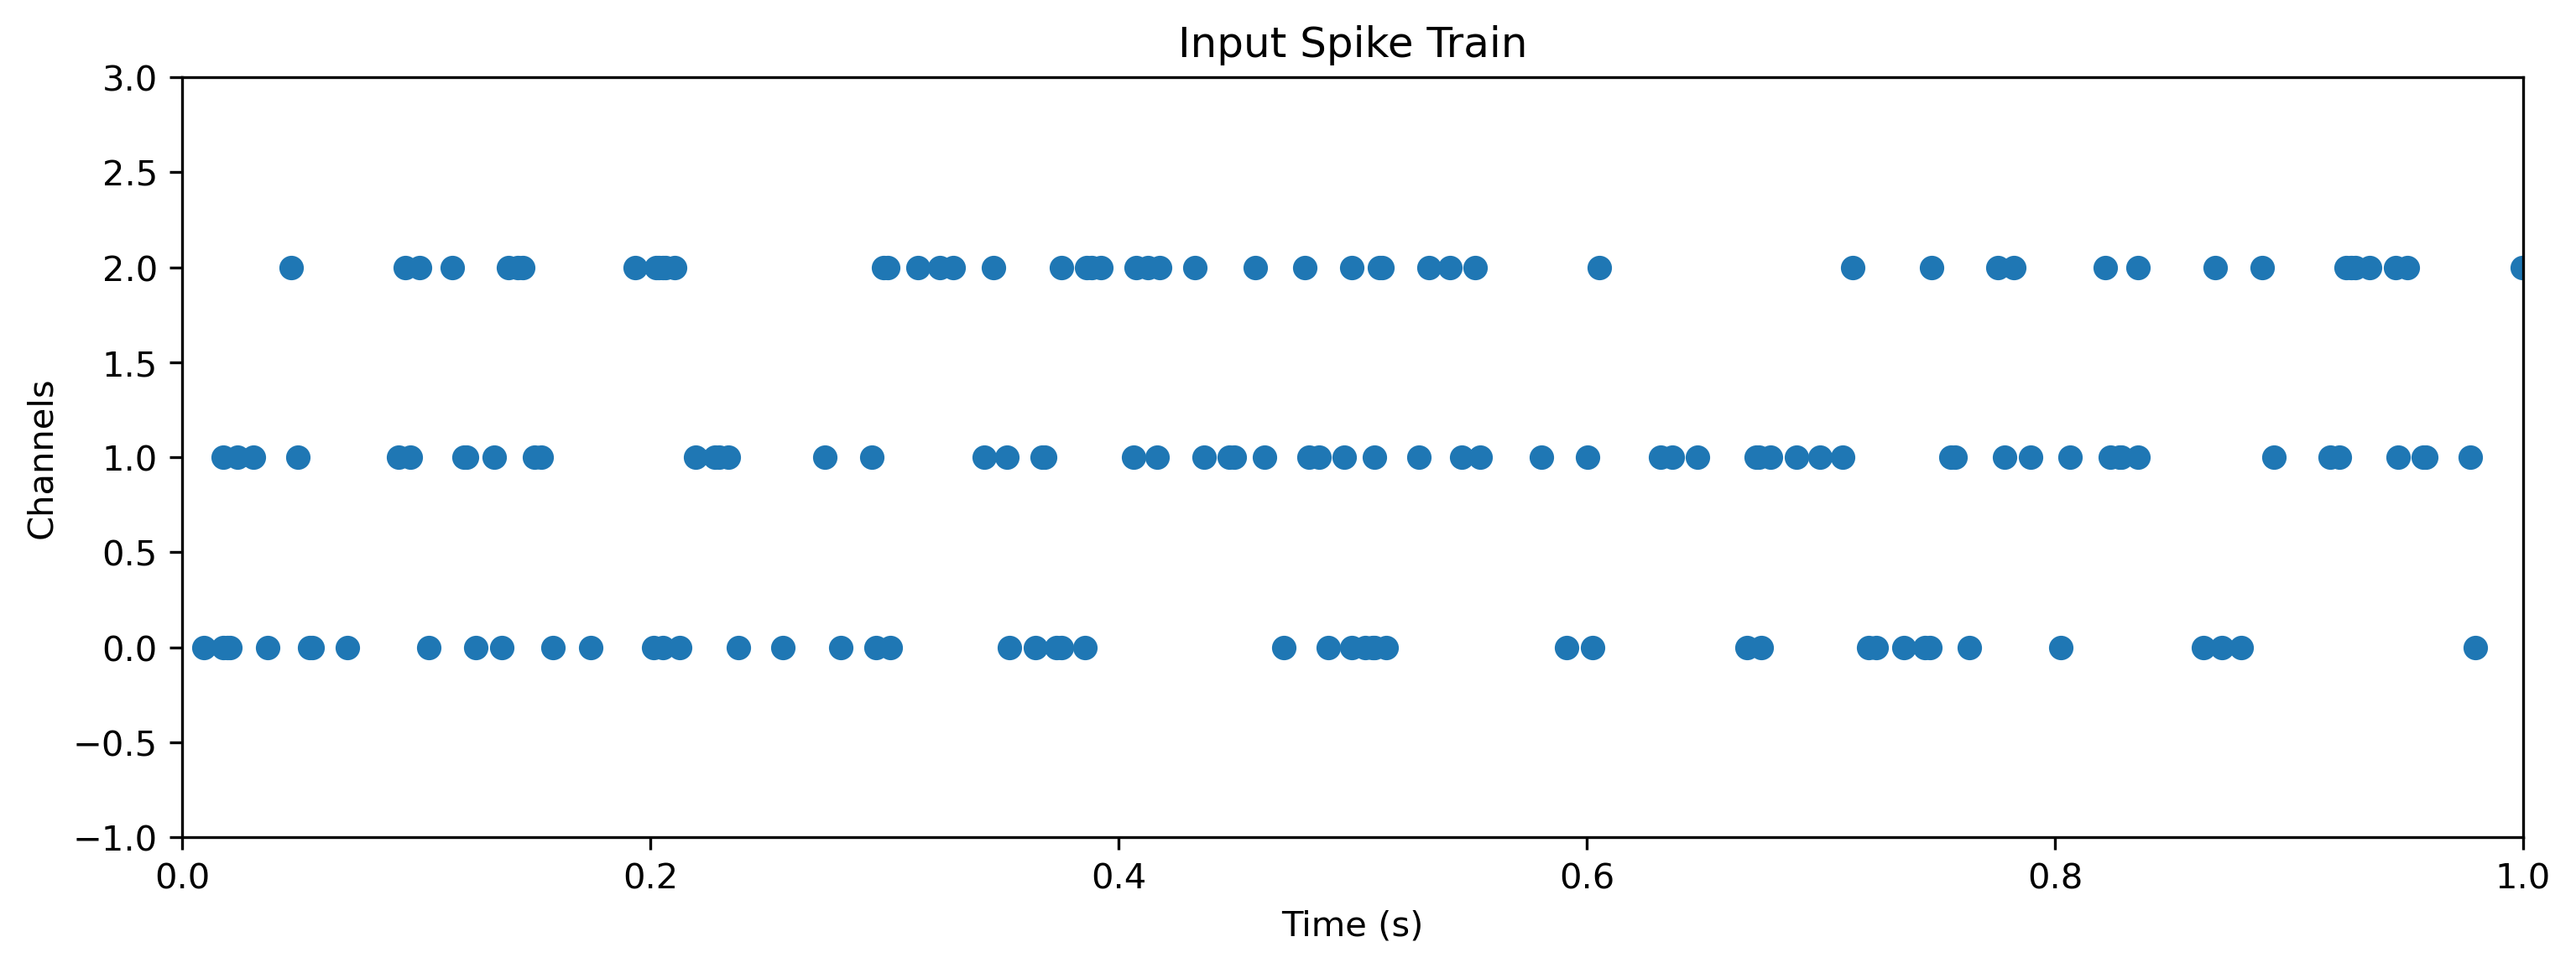

In [6]:
input_ts.plot();

## Run the model

Run the model to get output spikes, new_state and the record dictionary. Output spikes is the response of the system, new_state is the resulting state that the network got into, and the record dictionary stores the evolution of the currents. 

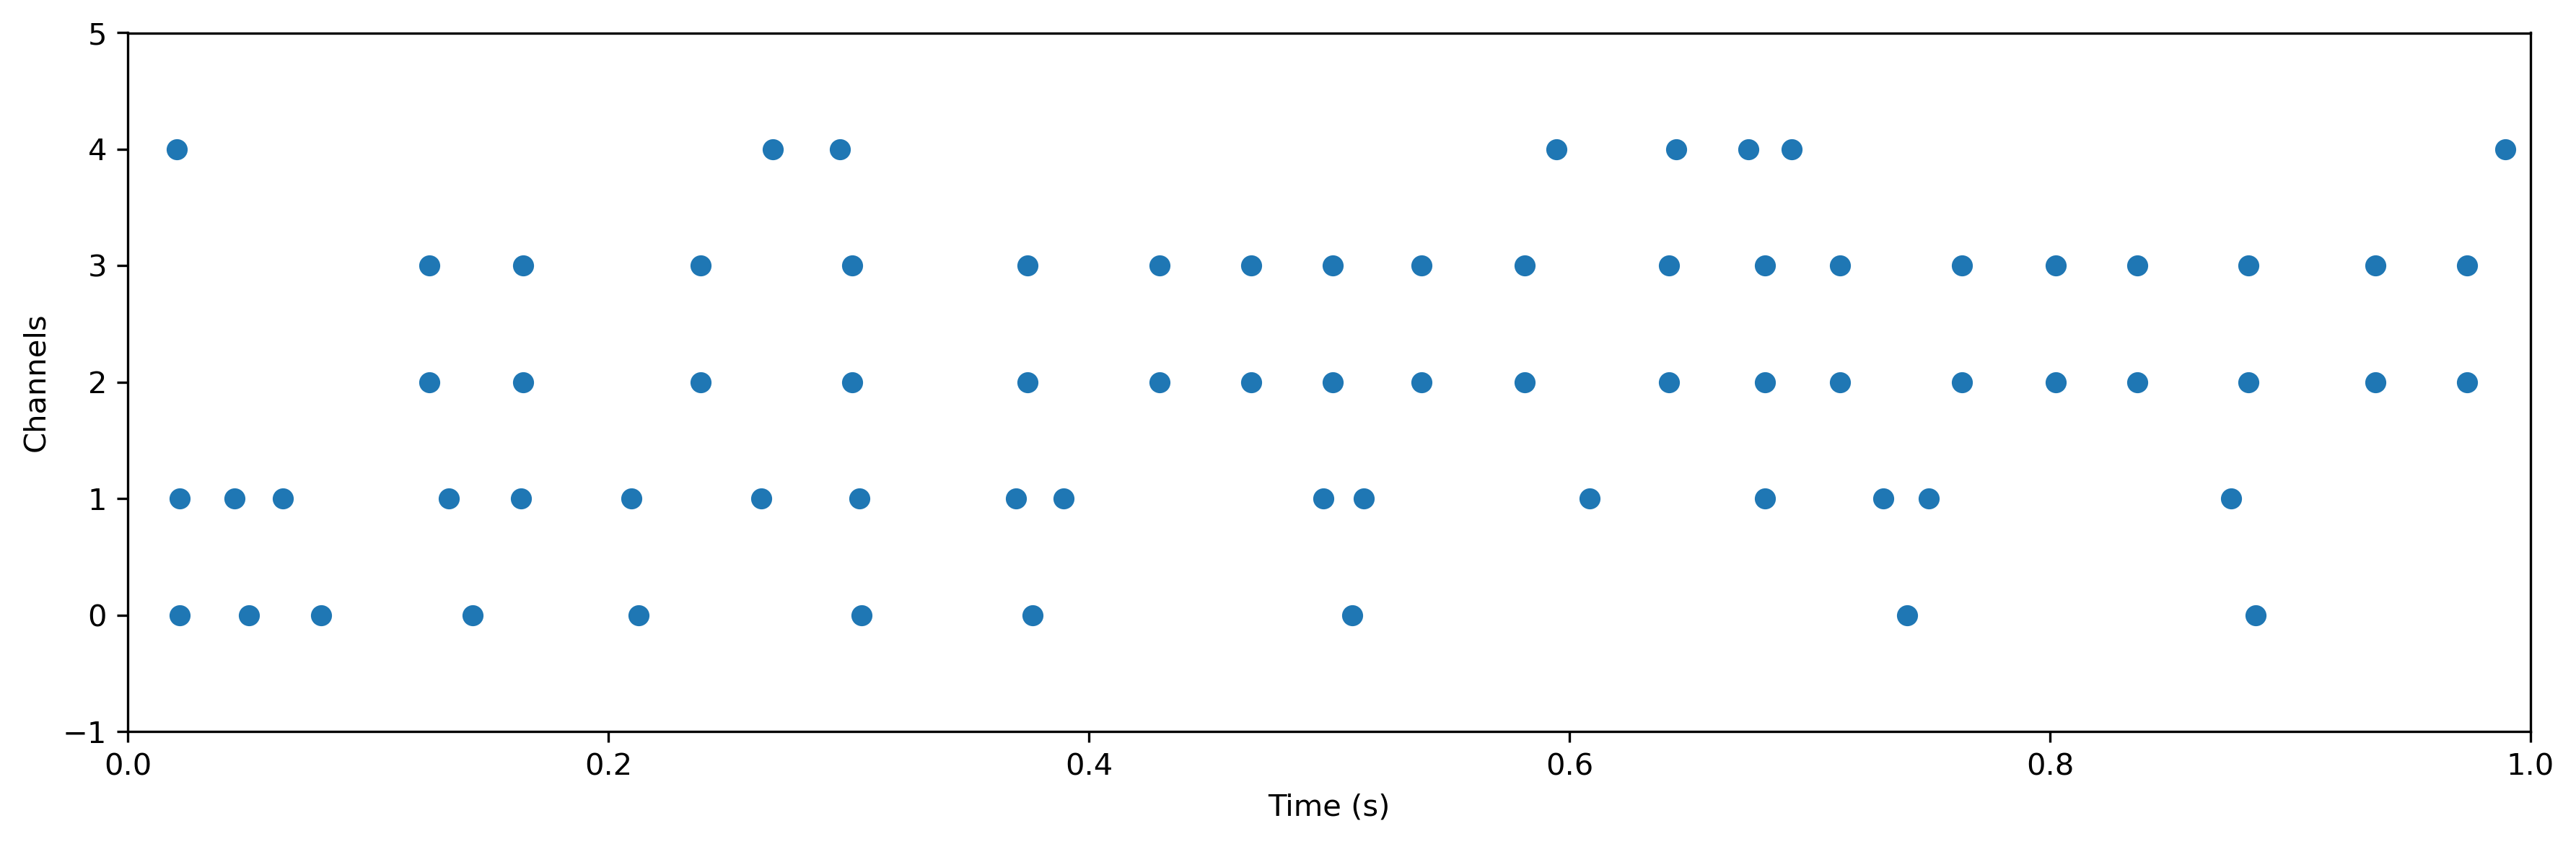

In [7]:
out_spikes, new_state, record_dict = modSE(input_ts.raster(dt = dt))
out = Figure.plot_spikes(out_spikes);

In [8]:
new_state.keys()

dict_keys(['_rng_key', 'Imem', 'Isyn', 'spikes', 'timer_ref'])

State dictionary stores 

`_rng_key`: key to be used in random number generation process

`Imem`: membrane currents of the in-device neurons at the last time step *(Nrec,)*

`Isyn`: synaptic currents of the synapses (AHP, NMDA, AMPA, GABA_A, GABA_B) of the neurons at the last time step *(Nrec,5,)*

`spikes` the last time-step output spikes of the neurons *(Nrec,)*

`timer_ref` the refractory timers of the neurons *(Nrec,)*

In [9]:
new_state

{'_rng_key': DeviceArray([2780287164, 1902174788], dtype=uint32),
 'Imem': DeviceArray([3.5603907e-12, 2.8116626e-10, 3.4607470e-10, 3.4607470e-10,
              5.0000000e-13], dtype=float32),
 'Isyn': DeviceArray([[1.7853595e-10, 5.0000000e-13, 5.0000000e-13, 5.0000000e-13,
               5.0000000e-13],
              [5.0000000e-13, 5.0000000e-13, 5.0000000e-13, 5.0000000e-13,
               4.0120013e-10],
              [5.0000000e-13, 5.0000000e-13, 2.2864967e-10, 2.2864967e-10,
               4.1667534e-11],
              [5.4873793e-11, 5.4873793e-11, 3.4251976e-11, 3.4251976e-11,
               1.4962794e-10],
              [9.0073099e-13, 8.1353517e-13, 8.5095923e-12, 8.5095923e-12,
               7.0175376e-12]], dtype=float32),
 'spikes': DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
 'timer_ref': DeviceArray([0.   , 0.   , 0.   , 0.   , 0.001], dtype=float32)}

In [10]:
# Should be initial values
modSE.state()

{'_rng_key': array([2780287164, 1902174788], dtype=uint32),
 'Imem': DeviceArray([5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13], dtype=float32),
 'Isyn': DeviceArray([[5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13],
              [5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13],
              [5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13],
              [5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13],
              [5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13]], dtype=float32),
 'spikes': DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
 'timer_ref': DeviceArray([0., 0., 0., 0., 0.], dtype=float32)}

In [11]:
assert modSE.state().keys() == new_state.keys()

In [12]:
record_dict.keys()

dict_keys(['input_data', 'spikes', 'Imem', 'Igaba_b', 'Igaba_a', 'Inmda', 'Iampa', 'Iahp'])

Record dictionary stores

`input_data` : rasterized input data provided to the network *(T,Nin,)*

`spikes` : output spikes through time passed *(T,Nrec,)*

`Imem` : The membrane currents of the neurons through time  *(T,Nrec,)*

`Iahp`, `Inmda`, `Iampa`, `Igaba_a`, `Igaba_b` : Synaptic currents of the neurons through time *(T,Nrec,5)*

In [13]:
record_dict

{'input_data': array([[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False,  True]]),
 'spikes': DeviceArray([[0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0.],
              ...,
              [0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0.]], dtype=float32),
 'Imem': DeviceArray([[5.0000000e-13, 5.0000000e-13, 5.0000000e-13, 5.0000000e-13,
               5.0000000e-13],
              [5.0000000e-13, 5.0000000e-13, 5.0000000e-13, 5.0000000e-13,
               5.0000000e-13],
              [5.0000000e-13, 5.0000000e-13, 5.0000000e-13, 5.0000000e-13,
               5.0000000e-13],
              ...,
              [3.9672649e-12, 2.9214395e-10, 3.2168423e-10, 3.2168423e-10,
               5.0000000e-13],
              [3.7580342e-12, 2.8701769e-10, 3.3485897e-10, 3.3485897e-1

Let's look at the membrane current change. The dashed lines stands for the spike-threshold current. That is, when membrane current hit the spike-threshold, it means that the module generated and event!

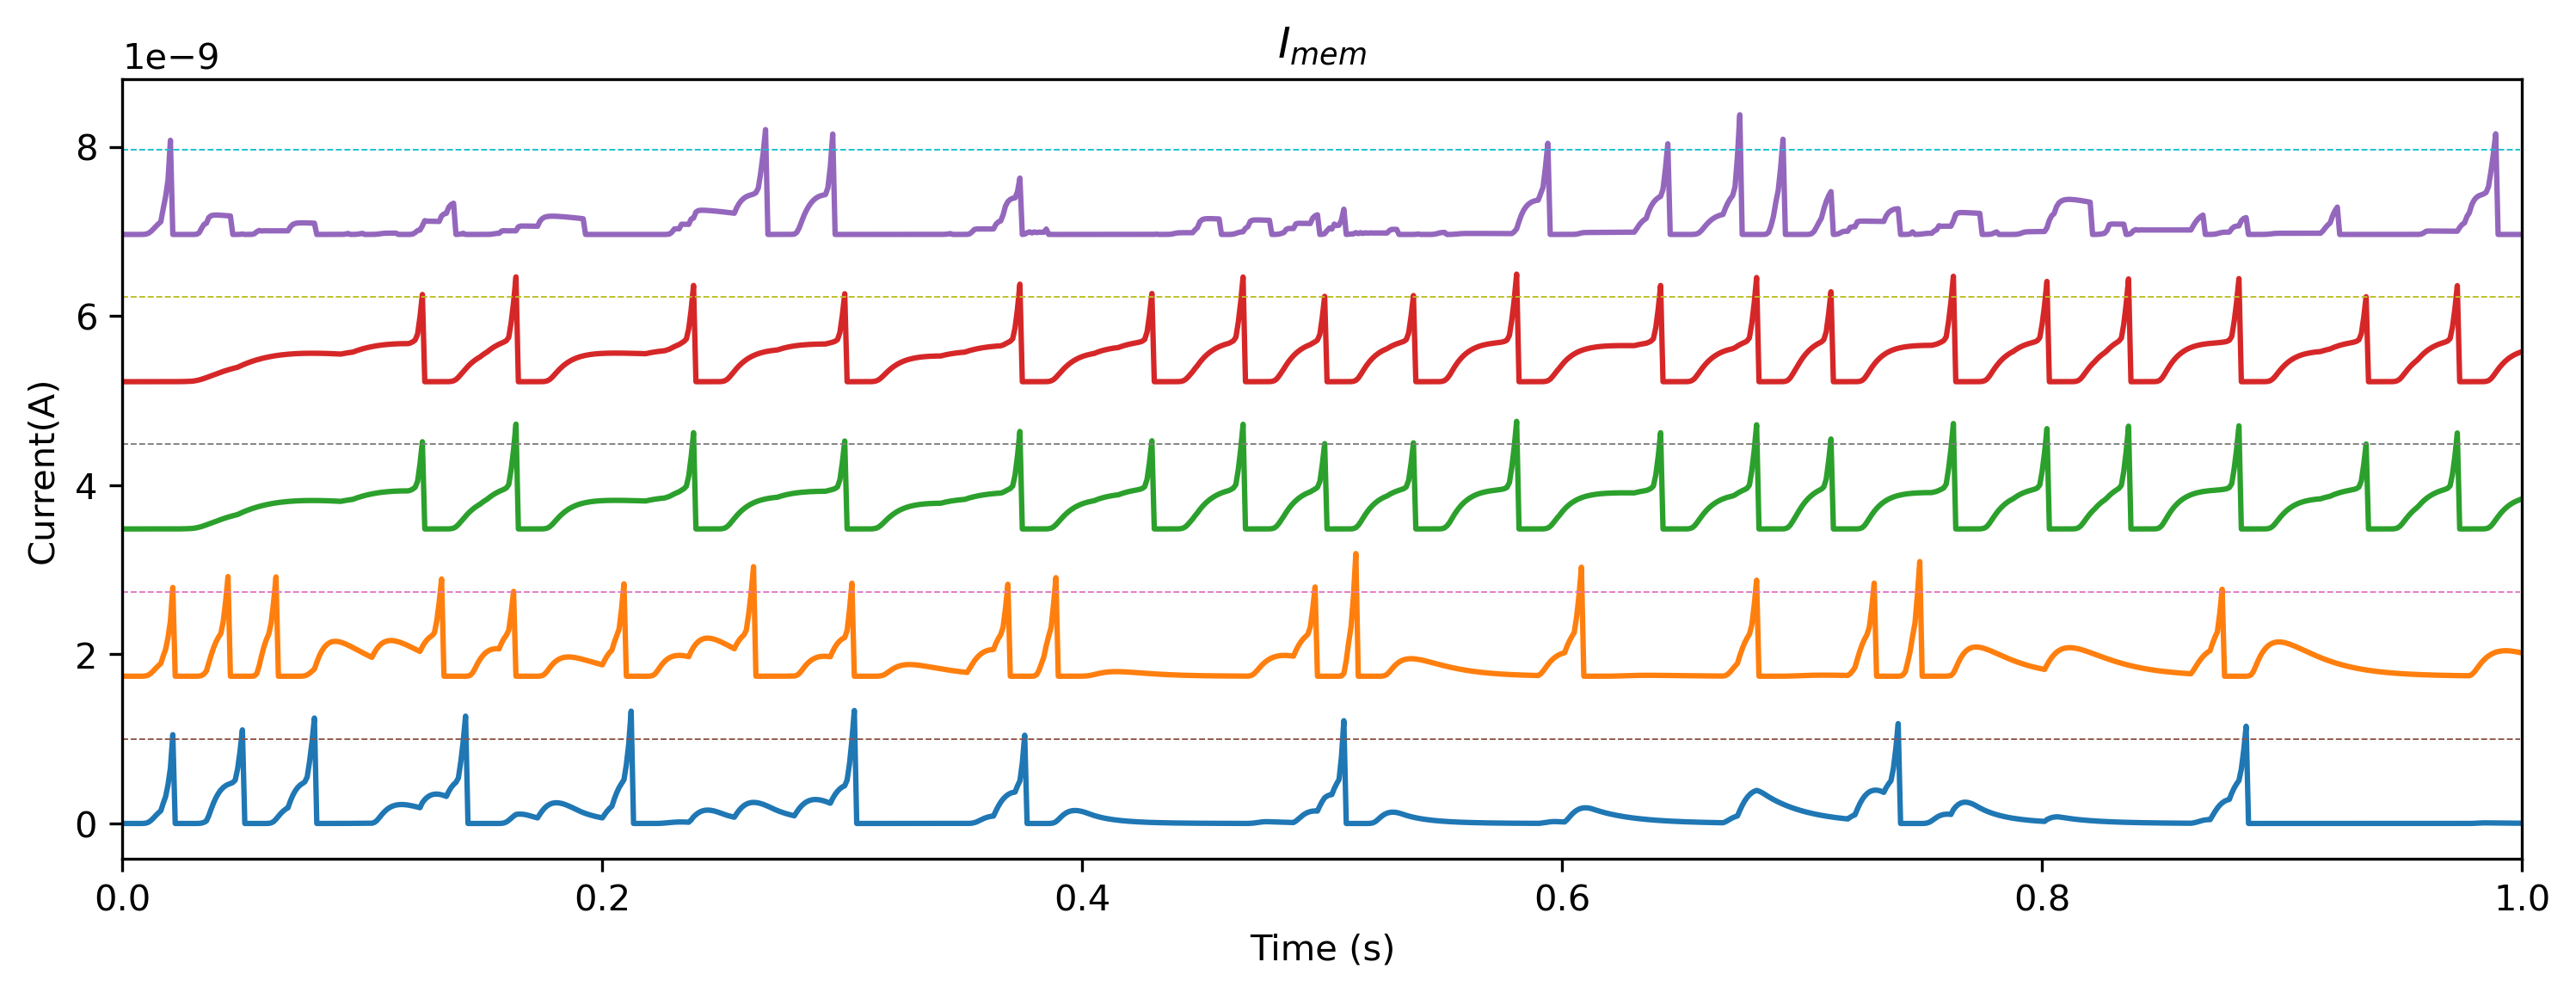

In [14]:
Imem, Ispkthr = Figure.plot_Ix(record_dict["Imem"], modSE.Ispkthr, name="$I_{mem}$")

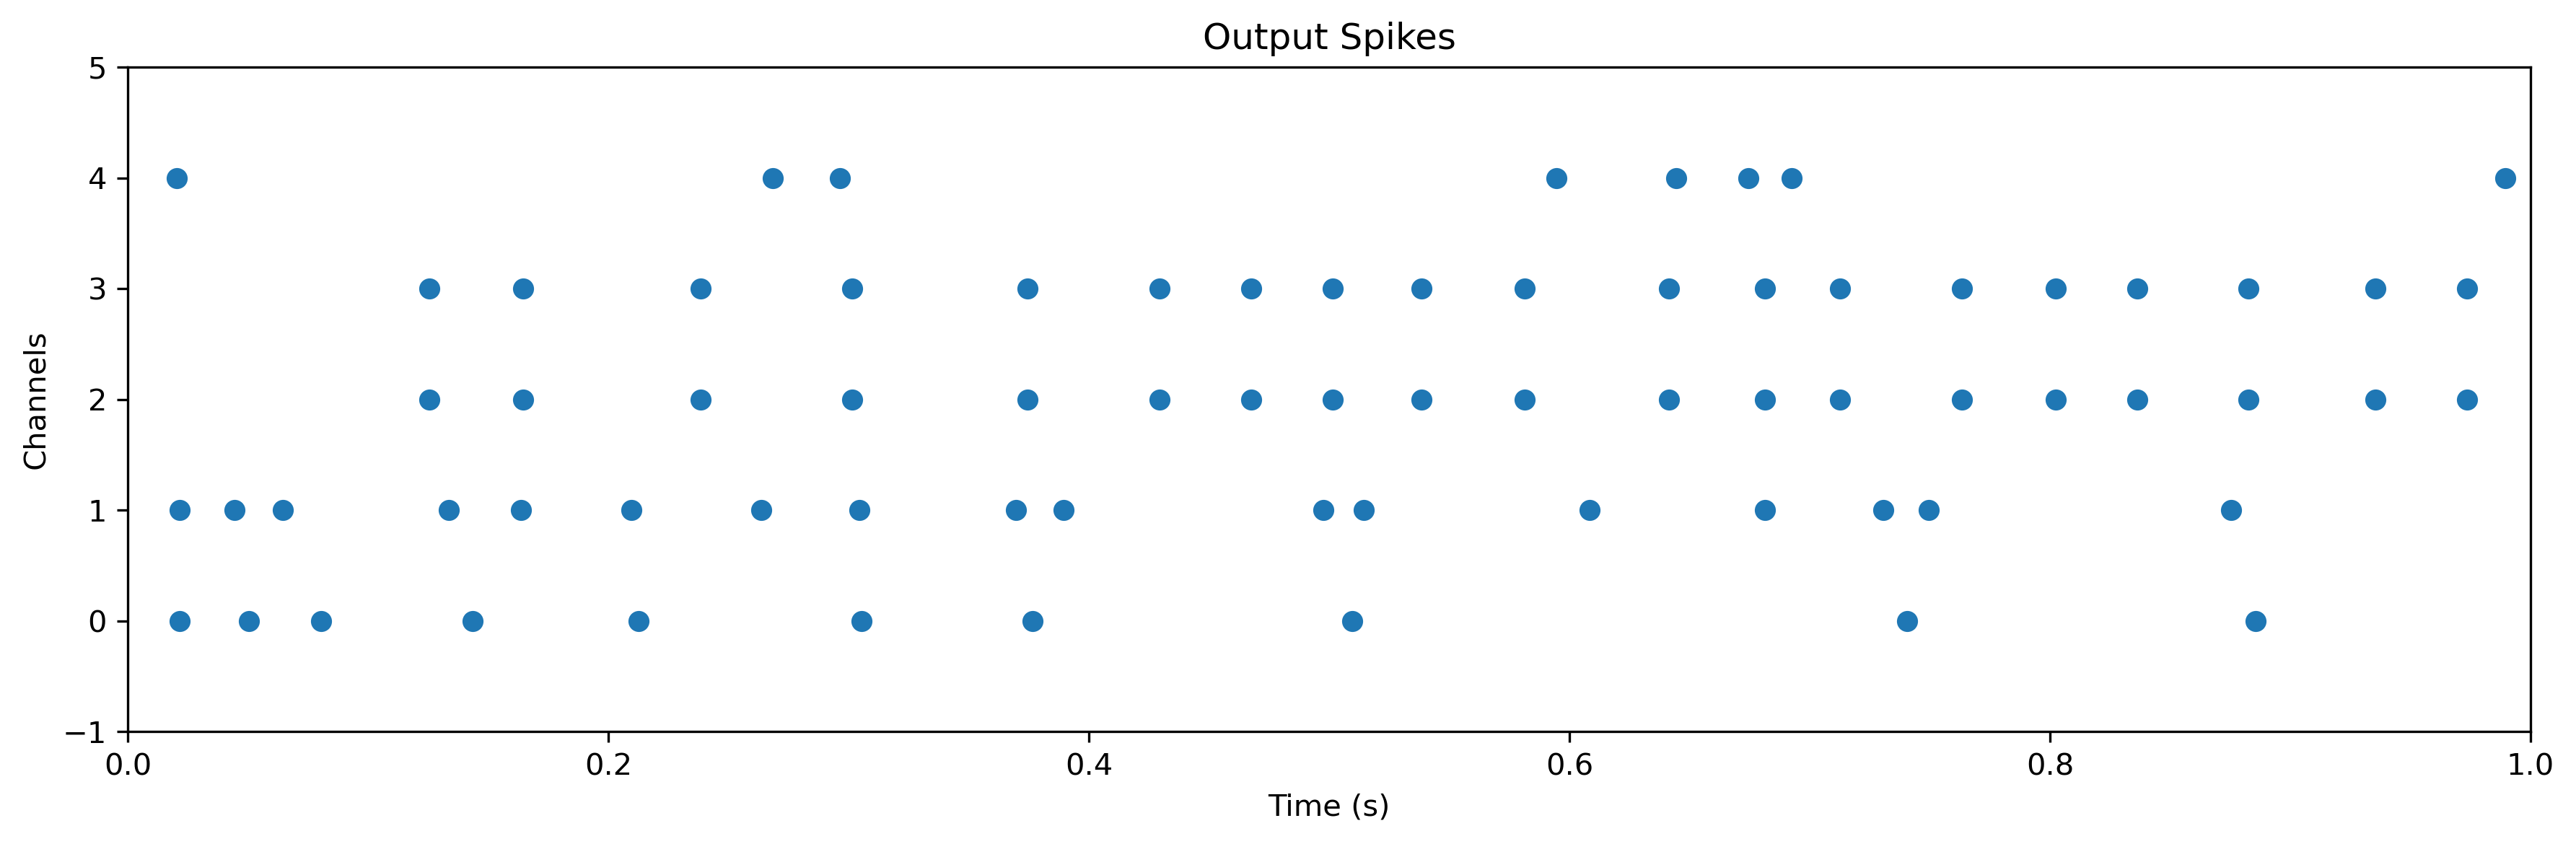

In [15]:
out = Figure.plot_spikes(out_spikes, name="Output Spikes");

One can investigate the synaptic currents of the neurons seperately or together.

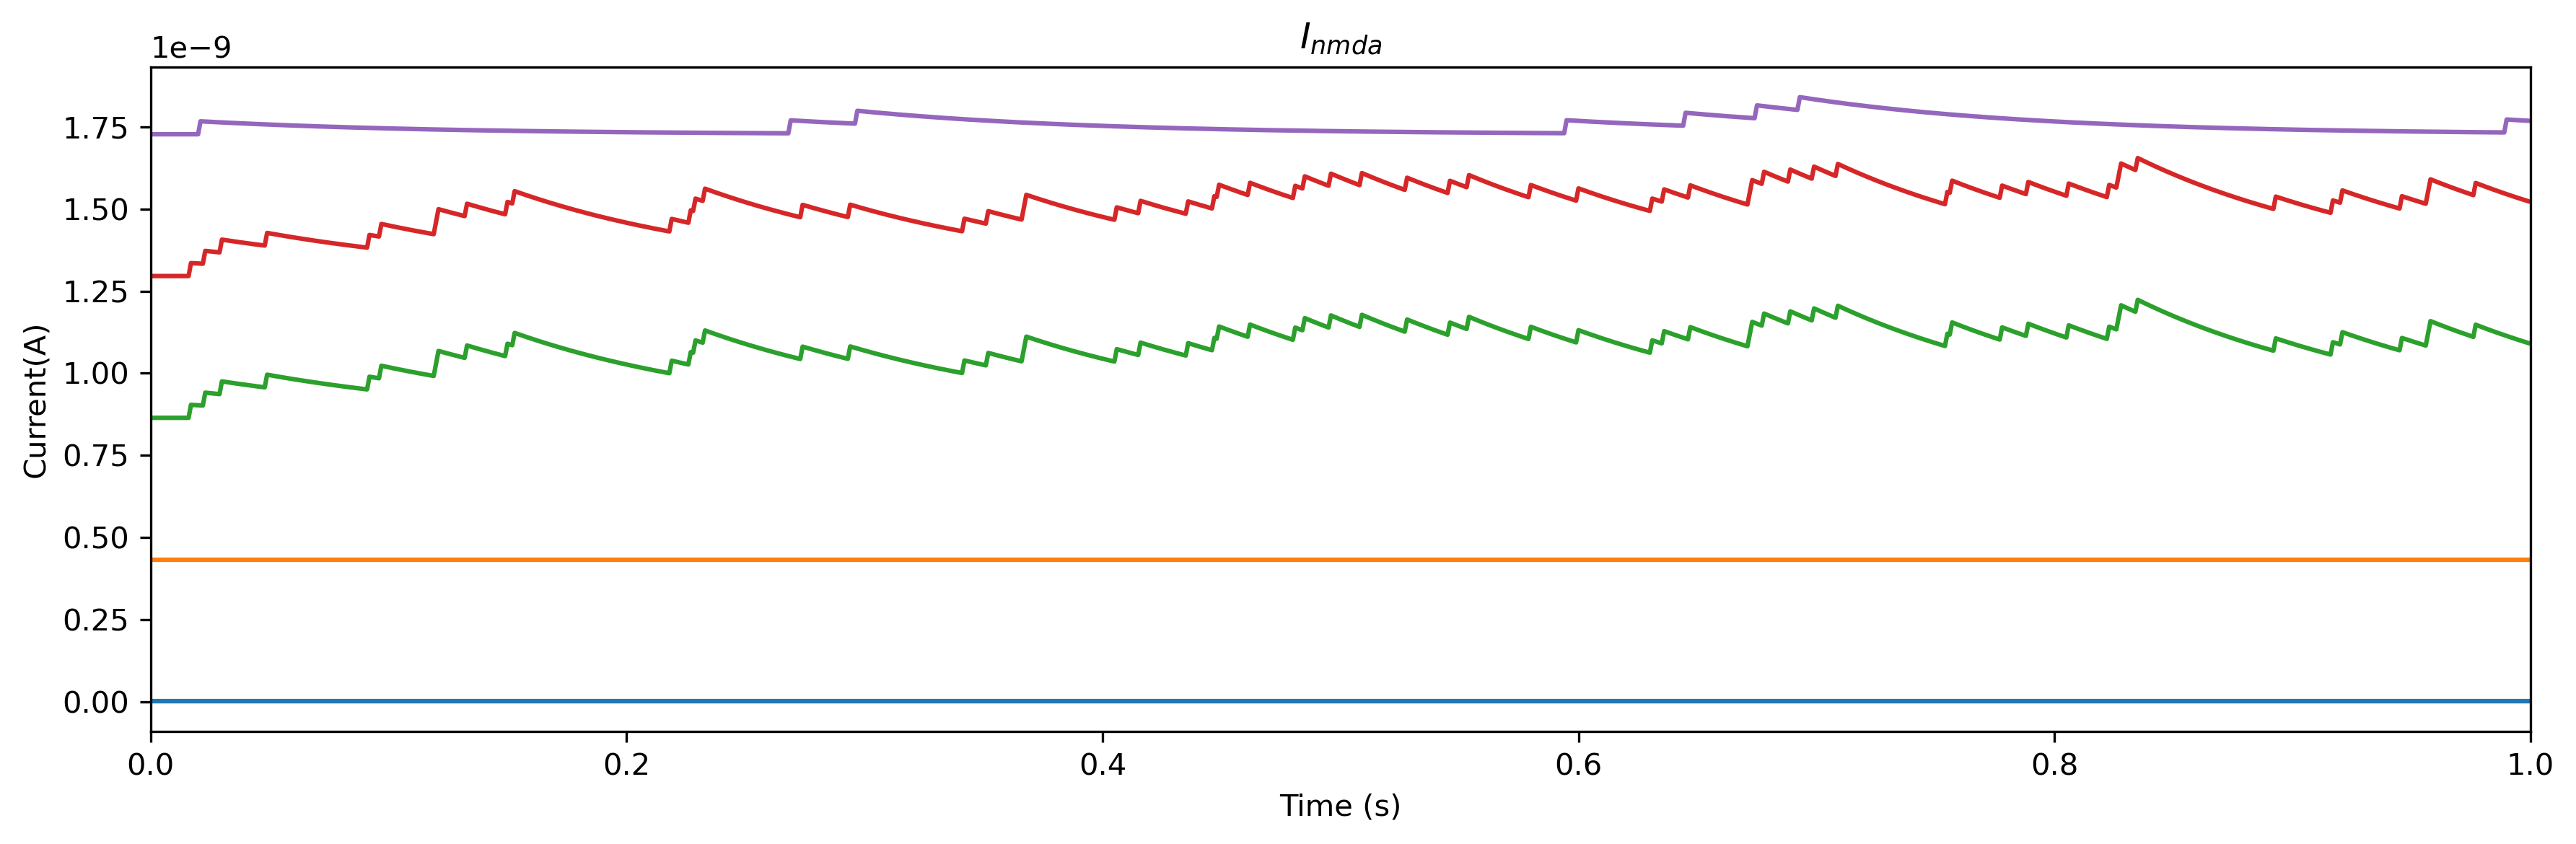

In [16]:
# Isyn = plot_Isyn(record_dict["Inmda"][:,2], "$I_{nmda}$")
Isyn = Figure.plot_Ix(record_dict["Inmda"], name="$I_{nmda}$")

In [17]:
modSE.parameters().keys()

dict_keys(['w_in', 'w_rec', 'Itau_mem', 'f_gain_mem', 'Itau_syn', 'f_gain_syn', 'Iw'])

The module has the parameters 

`w_in` : the input synapses from the virtual FPGA neurons to the real in-device neruons *(Nin, Nrec, 4)*

`w_rec` : recurrents synapses from real in-device neruons to real in-device neruons *(Nrec, Nrec, 4)*

`Itau_mem` : membrane current of the neurons *(Nrec,)*

`f_gain_mem` : gain parameter for the membrane weight current $ f_{gain} = \dfrac{I_{th}}{I_{\tau}}$ *(Nrec,)*

`Itau_syn` : synaptic leakage currents of 5 synapses (AHP, NMDA, AMPA, GABA_A, GABA_B) *(5,Nrec,)*

`f_gain_syn`: gain parameter for the weight current $ f_{gain} = \dfrac{I_{th}}{I_{\tau}}$ *(5,Nrec,)*

`Iw`: membrane weight current *(Nrec,)*

### DPI 
Assume that $I_w >> I_{\tau}$, and following $I_{syn} >> I_{th}$

$$\tau \dfrac{d}{dt} I_{syn} + I_{syn} = \dfrac{I_w I_{th}}{I_{\tau}}$$

$$I_{syn} (t) = \begin{cases} \dfrac{I_{th} I_{w}}{I_{\tau}}\left( 1 - e^{\frac{-(t-t_i^-)}{\tau}} \right) + I_{syn}^{-} e^{\frac{-(t-t_i^-)}{\tau}} ~~~~~~~~~~~~\text{charge} \\ I_{syn}^{+} \cdot e^{\frac{-(t-t_i^+)}{\tau}} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \text{discharge}\end{cases}$$


### Membrane

$$\left( 1 + \dfrac{I_{th}}{I_{mem}} \right) \tau \dfrac{d}{dt} I_{mem} + I_{mem} \left( 1 + \dfrac{I_{ahp}}{I_{\tau}} \right) = I_{mem_{\infty}} + f(I_{mem})$$




In [18]:
modSE.parameters()

{'w_in': DeviceArray([[[0., 0., 0., 1.],
               [0., 0., 0., 1.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 1.]],
 
              [[0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 1., 0.],
               [0., 0., 1., 0.],
               [0., 0., 0., 1.]],
 
              [[0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 1., 0., 0.]]], dtype=float32),
 'w_rec': DeviceArray([[[0., 0., 0., 0.],
               [0., 0., 0., 1.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 1., 0., 0.]],
 
              [[0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.]],
 
              [[2., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 0.],
               [0., 0., 0., 1

In [19]:
modSE.simulation_parameters().keys()

dict_keys(['dt', 'Io', 'f_tau_mem', 'f_tau_syn', 'f_t_ref', 'f_t_pulse', 't_pulse', 't_pulse_ahp', 'Idc', 'If_nmda', 't_ref', 'Ispkthr', 'Ireset'])

The module has the simulation parameters

`dt` :  The time step for the forward-Euler ODE solver

`Io` : Dark current in Amperes that flows through the transistors even at the idle state

`f_tau_mem` : Tau factor for membrane circuit. $f_{\tau} = \dfrac{U_T}{\kappa \cdot C}$, $f_{\tau} = I_{\tau} \cdot \tau$

`f_tau_syn` : A vector of tau factors in the following order: [AHP, NMDA, AMPA, GABA_A, GABA_B]

`f_t_ref` : The factor of conversion from refractory period in seconds to refractory period bias current in Amperes

`f_t_pulse` :  The factor of conversion from pulse width in seconds to pulse width bias current in Amperes

`t_pulse` : the width of the pulse in seconds produced by virtue of a spike

`t_pulse_ahp` : reduced pulse width also look at ``t_pulse`` and ``fpulse_ahp``

`Idc` : Constant DC current in Amperes, injected to membrane

`If_nmda` : The NMDA gate current in Amperes setting the NMDA gating voltage. If $V_{mem} > V_{nmda}$ : The $I_{syn_{NMDA}}$ current is added up to the input current, else it cannot

`t_ref` : refractory period in seconds, limits maximum firing rate

`Ispkthr` : Spiking threshold current in with shape *(Nrec,)*

`Ireset` : Reset current after spike generation with shape *(Nrec,)*


In [20]:
modSE.simulation_parameters()

{'dt': 0.001,
 'Io': 5e-13,
 'f_tau_mem': 1.4184397163120565e-13,
 'f_tau_syn': DeviceArray([7.0921985e-13, 7.0921987e-14, 7.0921985e-13, 7.0921987e-14,
              3.5460992e-13], dtype=float32),
 'f_t_ref': 1.4184397163120566e-14,
 'f_t_pulse': 1.4184397163120566e-14,
 't_pulse': 1e-05,
 't_pulse_ahp': 1.0000000000000002e-06,
 'Idc': 5e-13,
 'If_nmda': 5e-13,
 't_ref': 0.01,
 'Ispkthr': DeviceArray([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09], dtype=float32),
 'Ireset': DeviceArray([5.e-13, 5.e-13, 5.e-13, 5.e-13, 5.e-13], dtype=float32)}

In [21]:
# modSE.tau_syn?
modSE.tau_syn

DeviceArray([[0.10131712, 0.01013171, 0.10131712, 0.01013171, 0.05065856],
             [0.10131712, 0.01013171, 0.10131712, 0.01013171, 0.05065856],
             [0.10131712, 0.01013171, 0.10131712, 0.01013171, 0.05065856],
             [0.10131712, 0.01013171, 0.10131712, 0.01013171, 0.05065856],
             [0.10131712, 0.01013171, 0.10131712, 0.01013171, 0.05065856]],            dtype=float32)

In [22]:
# modSE.tau_gaba_a?
modSE.tau_gaba_a

DeviceArray([0.01013171, 0.01013171, 0.01013171, 0.01013171, 0.01013171],            dtype=float32)

In [23]:
# modSE.tau_mem?
modSE.tau_mem

DeviceArray([0.02026342, 0.02026342, 0.02026342, 0.02026342, 0.02026342],            dtype=float32)

The model is also capable of extracting device bias currents depending on the parameters and simulation parameters used in the model

In [24]:
modSE.biases

['IF_AHTAU_N',
 'IF_AHTHR_N',
 'IF_AHW_P',
 'IF_BUF_P',
 'IF_CASC_N',
 'IF_DC_P',
 'IF_NMDA_N',
 'IF_RFR_N',
 'IF_TAU1_N',
 'IF_TAU2_N',
 'IF_THR_N',
 'NPDPIE_TAU_F_P',
 'NPDPIE_TAU_S_P',
 'NPDPIE_THR_F_P',
 'NPDPIE_THR_S_P',
 'NPDPII_TAU_F_P',
 'NPDPII_TAU_S_P',
 'NPDPII_THR_F_P',
 'NPDPII_THR_S_P',
 'PS_WEIGHT_EXC_F_N',
 'PS_WEIGHT_EXC_S_N',
 'PS_WEIGHT_INH_F_N',
 'PS_WEIGHT_INH_S_N',
 'PULSE_PWLK_P',
 'R2R_P']

In [25]:
modSE.IF_AHTAU_N

In [26]:
print(modSE.IF_AHTAU_N.to_json())

{
    "value0": {
        "paramName": "IF_AHTAU_N",
        "coarseValue": 0,
        "fineValue": 119,
        "type": "N"
    }
}


Let's investigate the connections built. Here the internal and external connections arriving to neuron 0 is targeted. 

`Figure.plot_Ix()` utility function draw guides to observe the synaptic current increase depending on the spike provided. In the case that a input connection is investigated, the external input spikes are drawn with guides, 
else if a recurrent connections are investigated, the spikes routed from pre-synaptic neurons to post-synaptic neuron are demonstrated.

Let's have a look at post-synaptic neuron 4

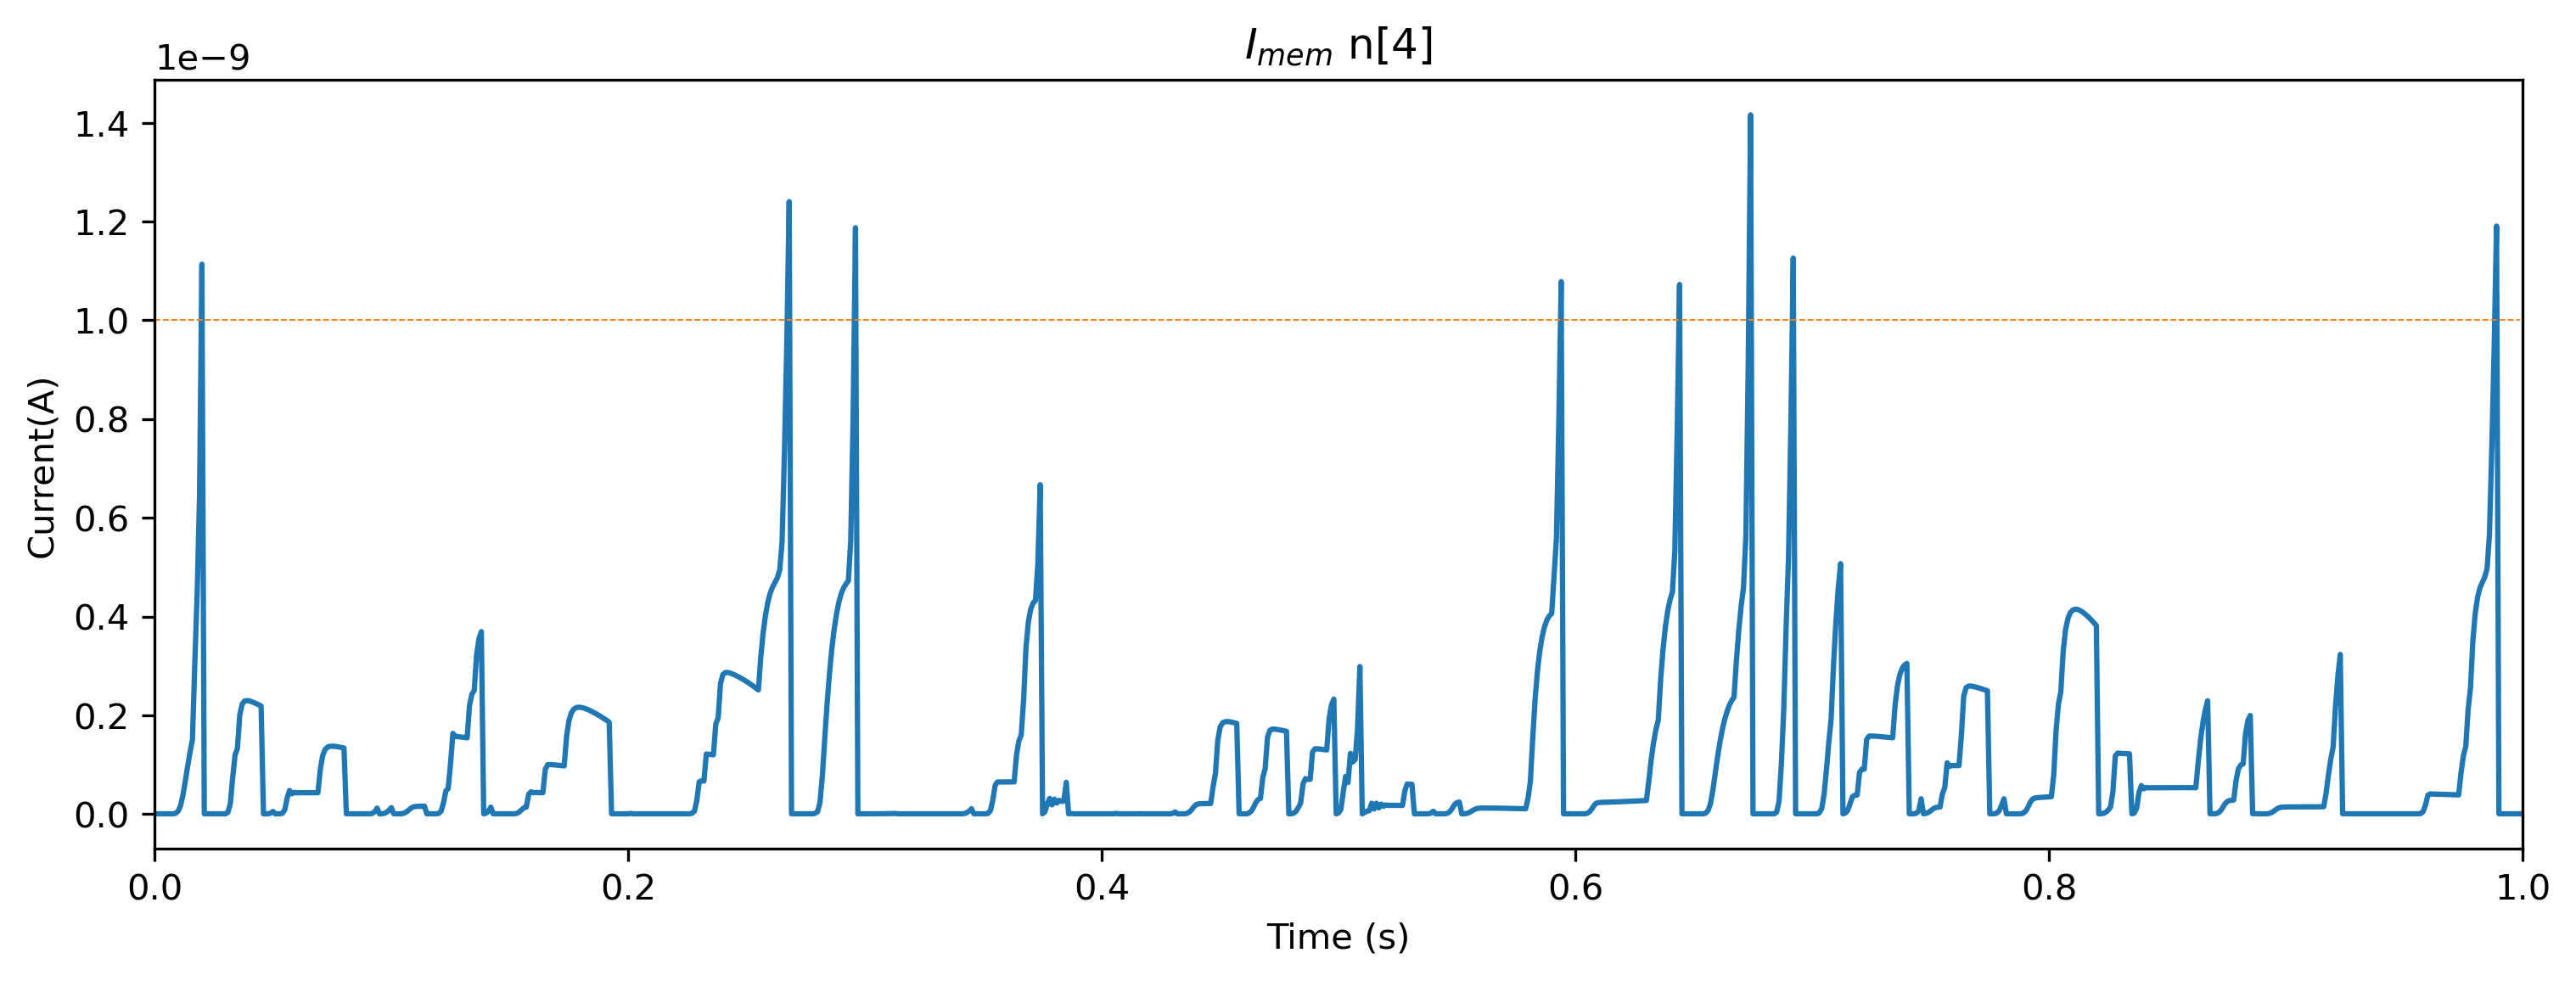

In [27]:
Imem, Ispkthr = Figure.plot_Ix(record_dict["Imem"][:,4], modSE.Ispkthr[4], name="$I_{mem}$ n[4]")

## Excitatory Connections to neuron 4

(non-periodic TSContinuous object `$I_{AMPA}$ n[4]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 3. Events: 128,
 ['s[0]x1.0', 's[1]x1.0', 'n[3]x1.0'])

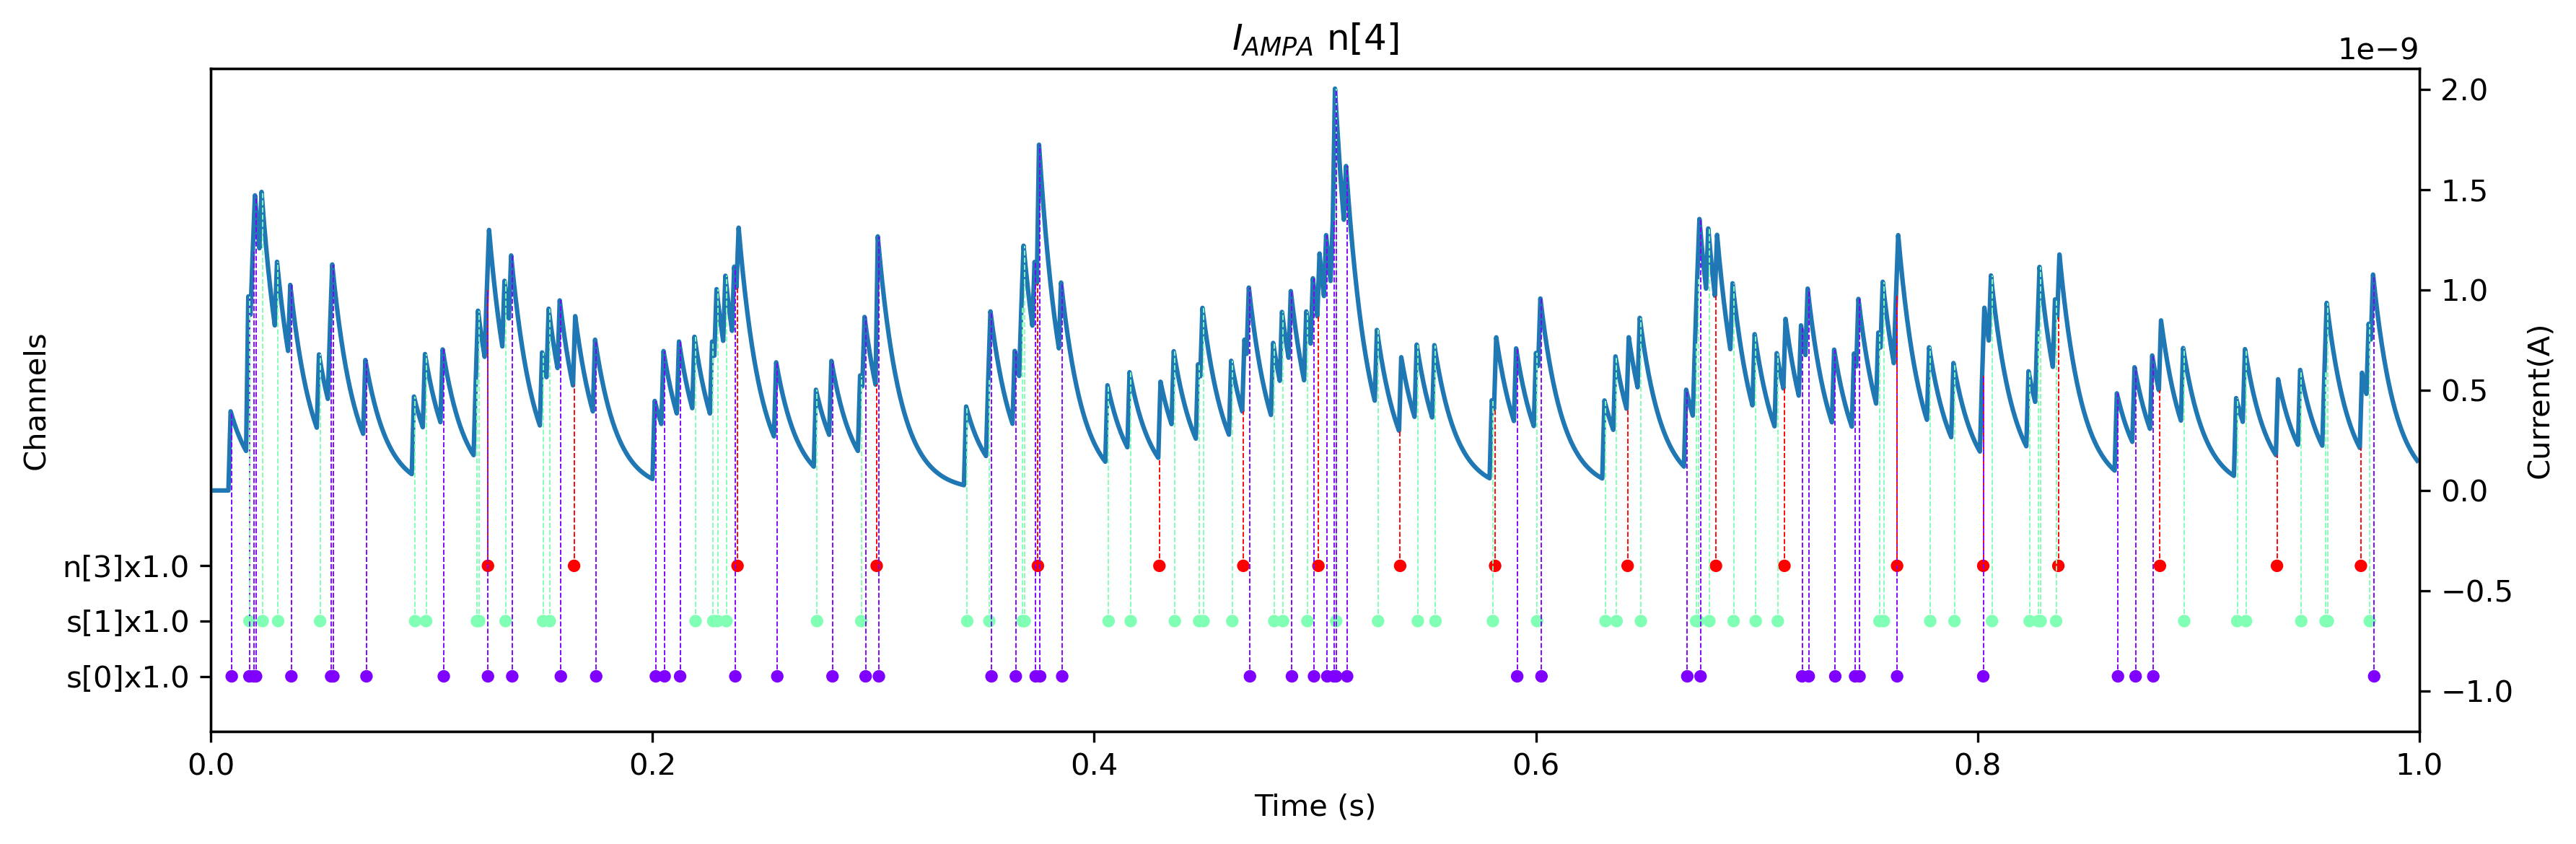

In [28]:
Figure.plot_Isyn_trace(modSE, record_dict, post=4, syn_type="ampa")

(non-periodic TSContinuous object `$I_{NMDA}$ n[4]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 1. Events: 8,
 ['n[4]x1.0'])

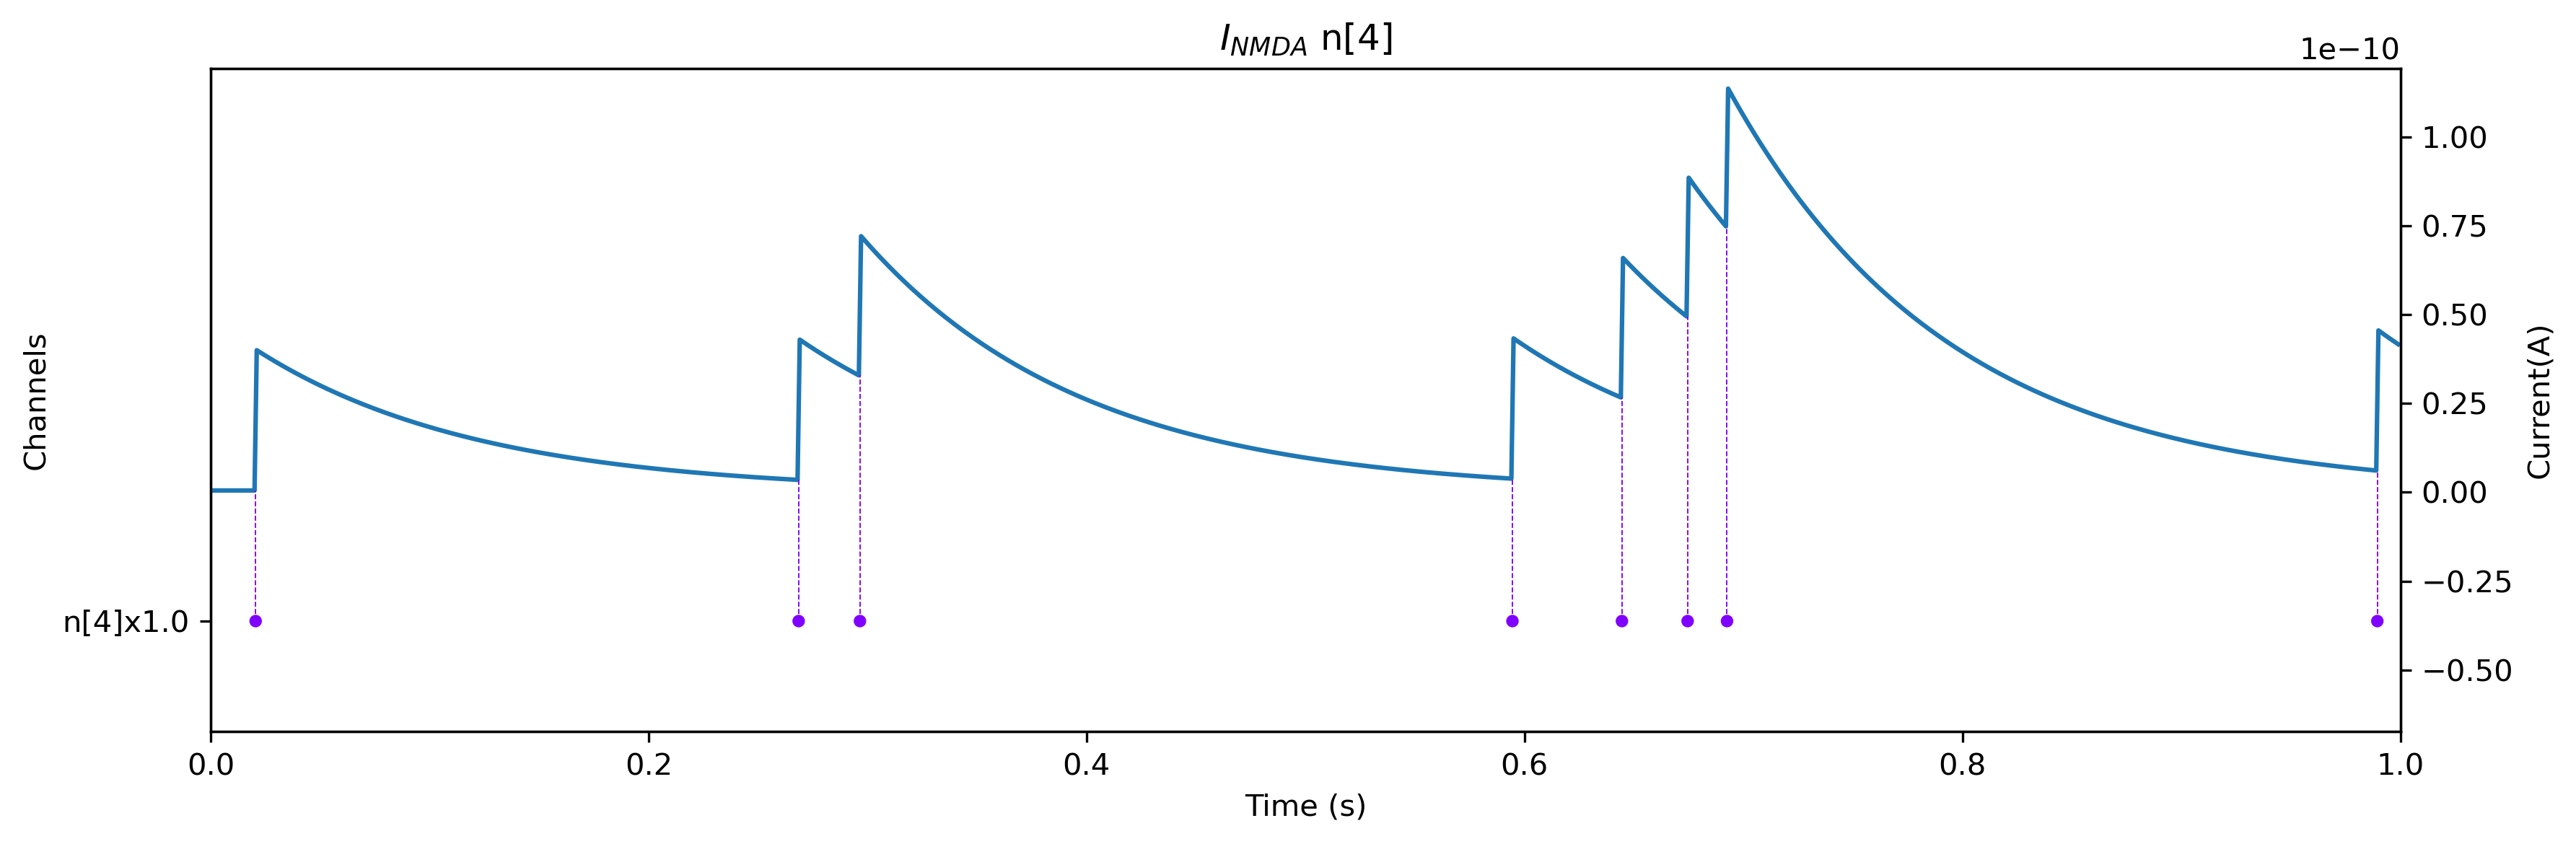

In [29]:
Figure.plot_Isyn_trace(modSE, record_dict, post=4, syn_type="nmda")

## Inhibitory Connections to Neuron 4

(non-periodic TSContinuous object `$I_{GABA_A}$ n[4]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 2. Events: 61,
 ['s[2]x1.0', 'n[0]x1.0'])

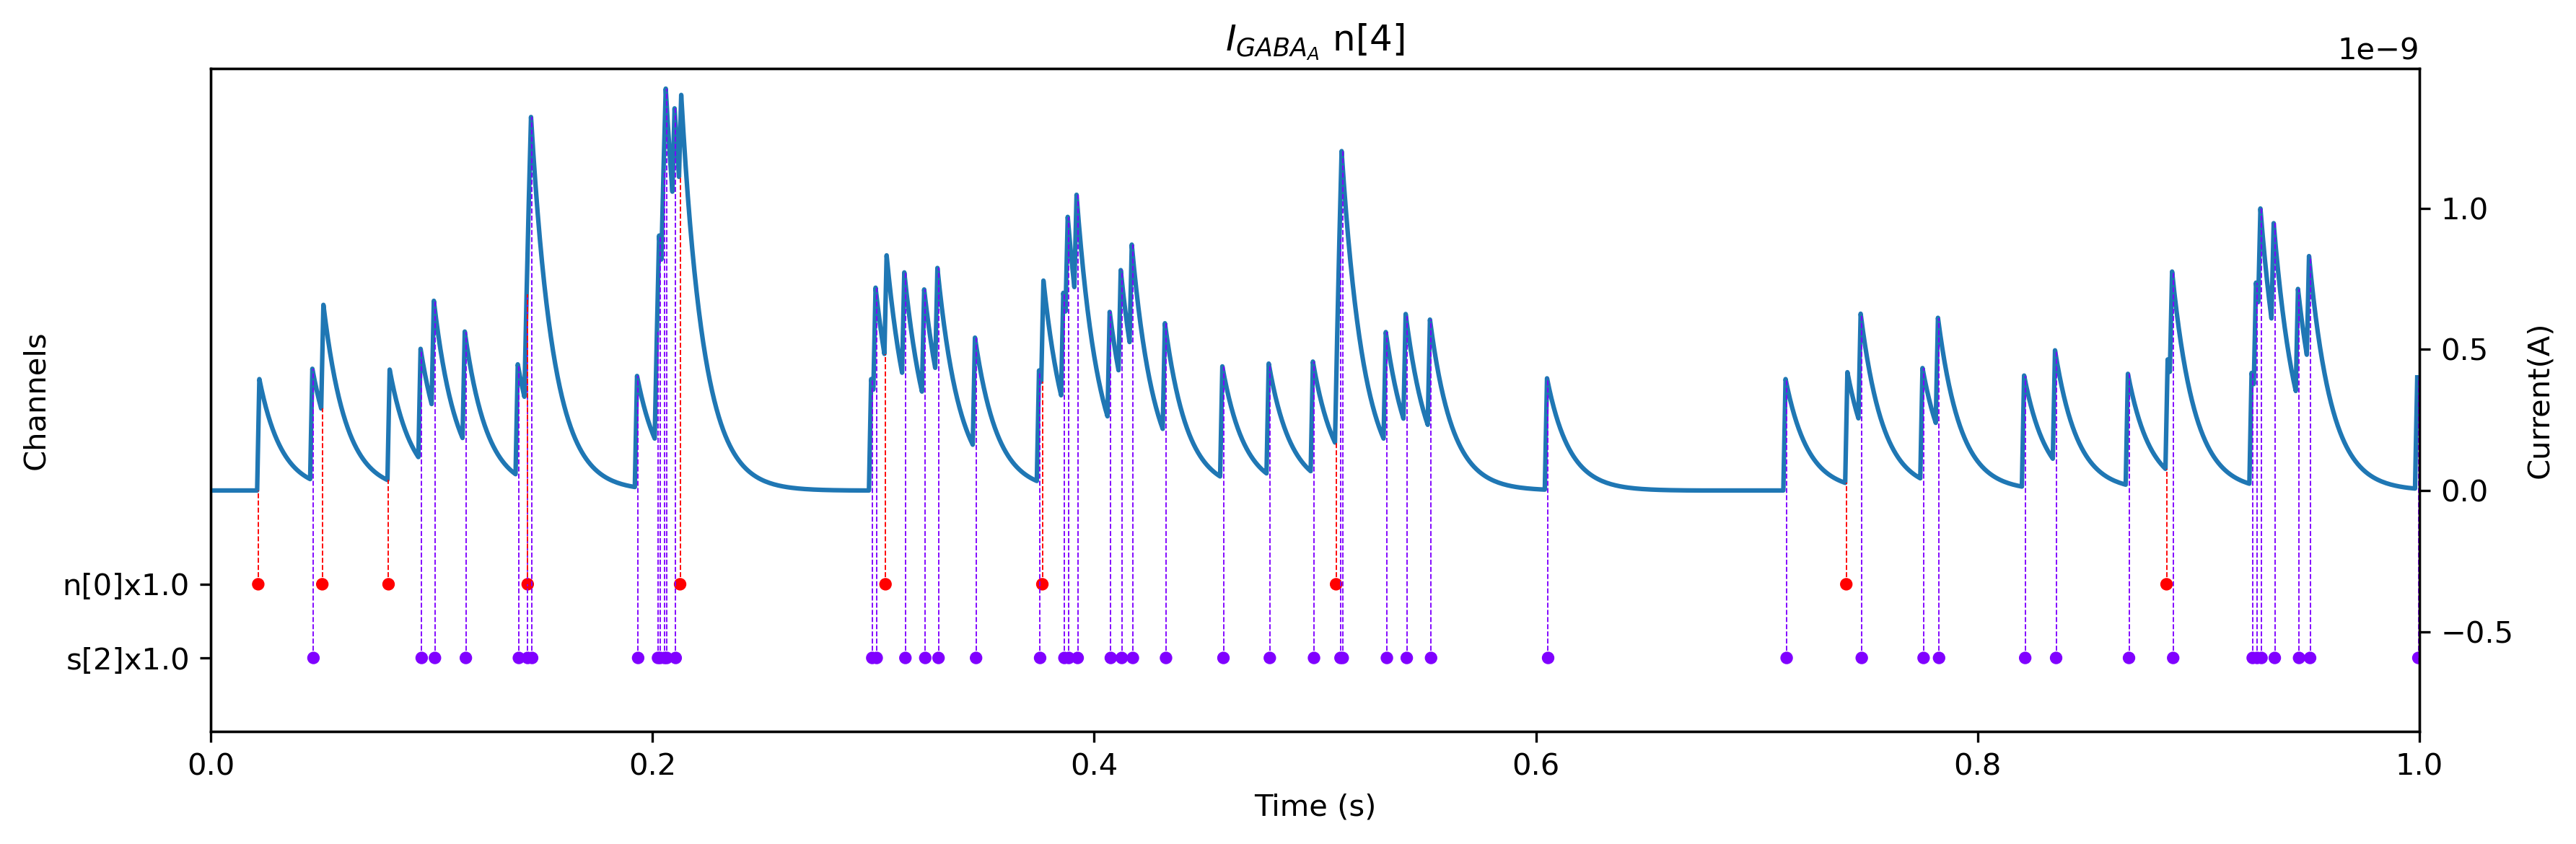

In [30]:
Figure.plot_Isyn_trace(modSE, record_dict, post=4, syn_type="gaba_a")

(non-periodic TSContinuous object `$I_{GABA_B}$ n[4]` from t=0.0 to 1.0. Samples: 1000. Channels: 1,
 Empty `TSEvent` object `` from t=0.0 to t=1.0.,
 [])

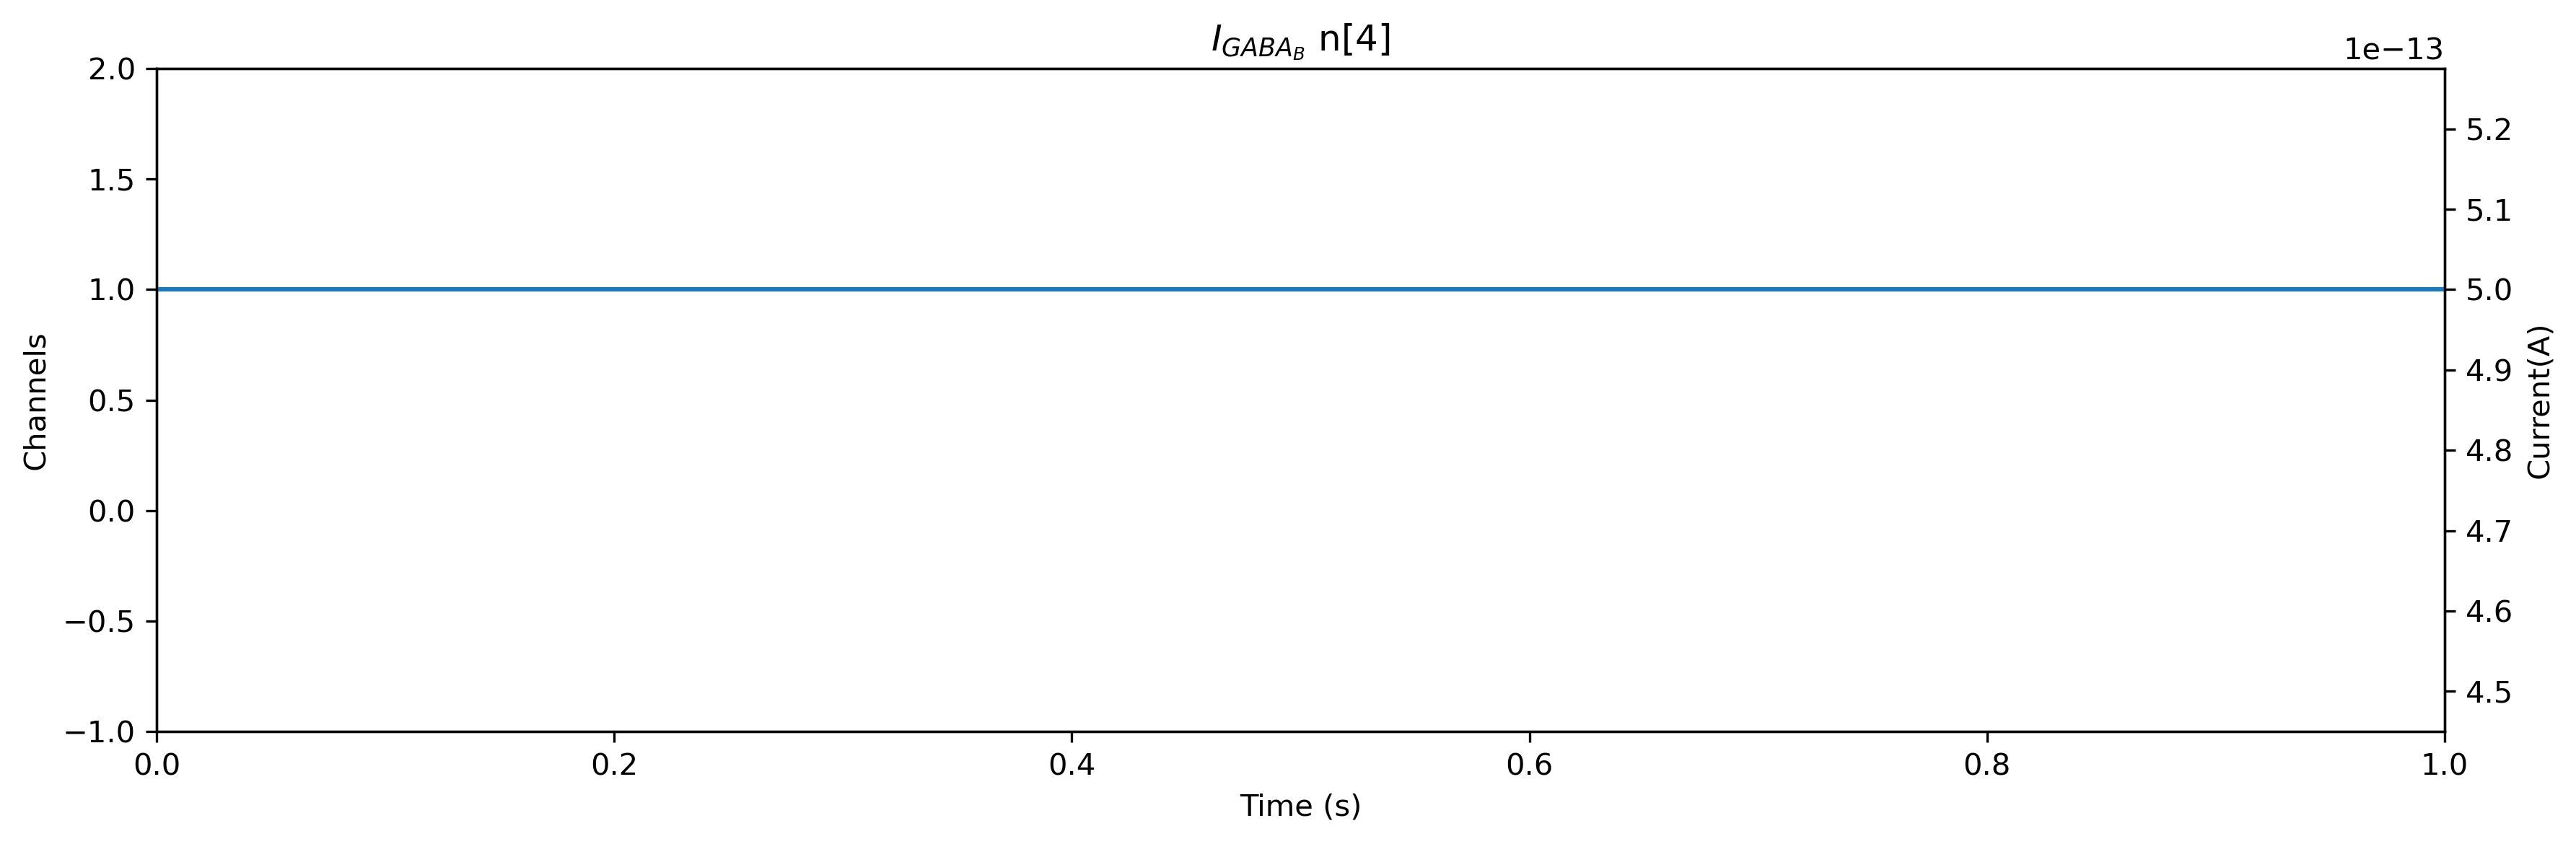

In [31]:
Figure.plot_Isyn_trace(modSE, record_dict, post=4, syn_type="gaba_b")

Since the module is using the `jax` backend, we could train the networks and using just-in-time compilation facility, make things faster than it used to be.

In [32]:
import jax

In [33]:
j_modSE = jax.jit(modSE)

In [34]:
# %%timeit
j_out_spikes, j_new_state, j_record_dict = j_modSE(input_ts.raster(dt = dt))

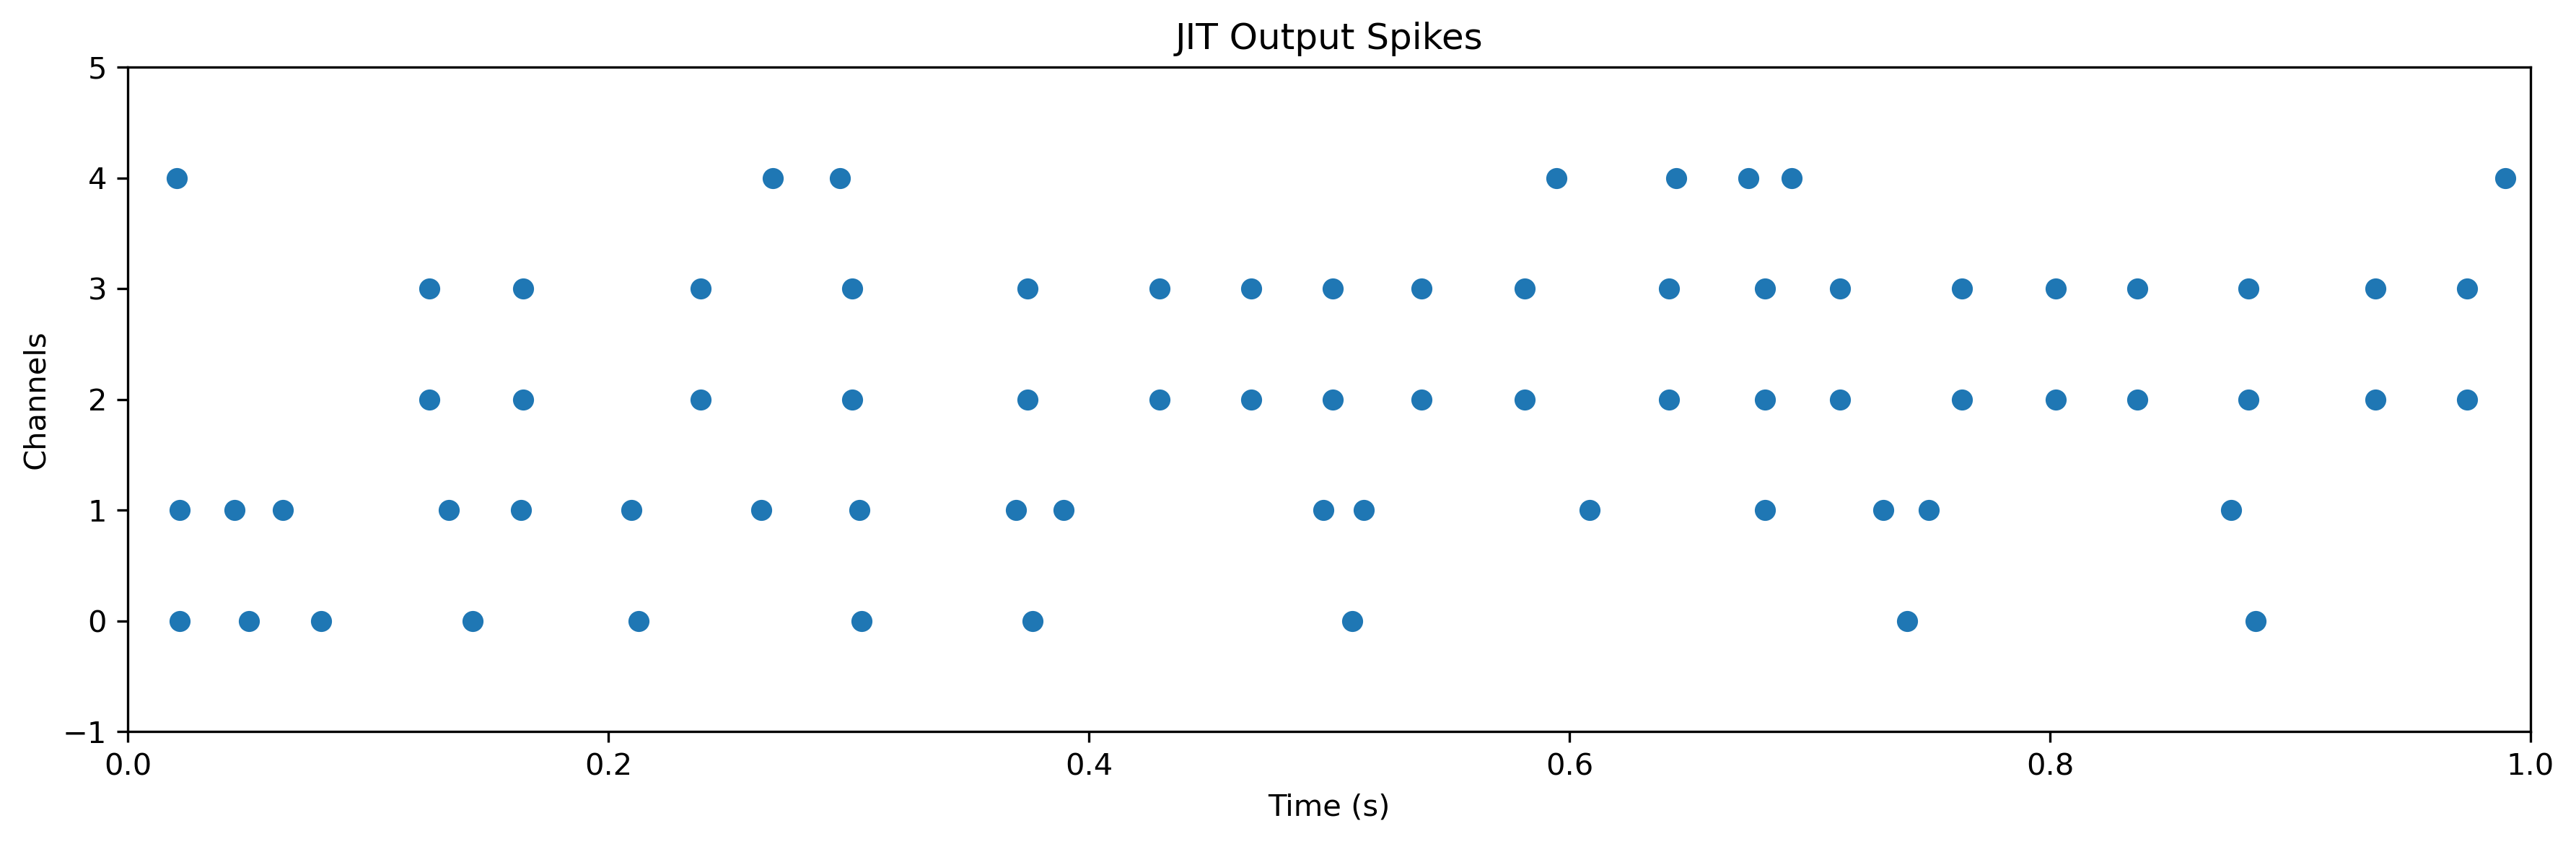

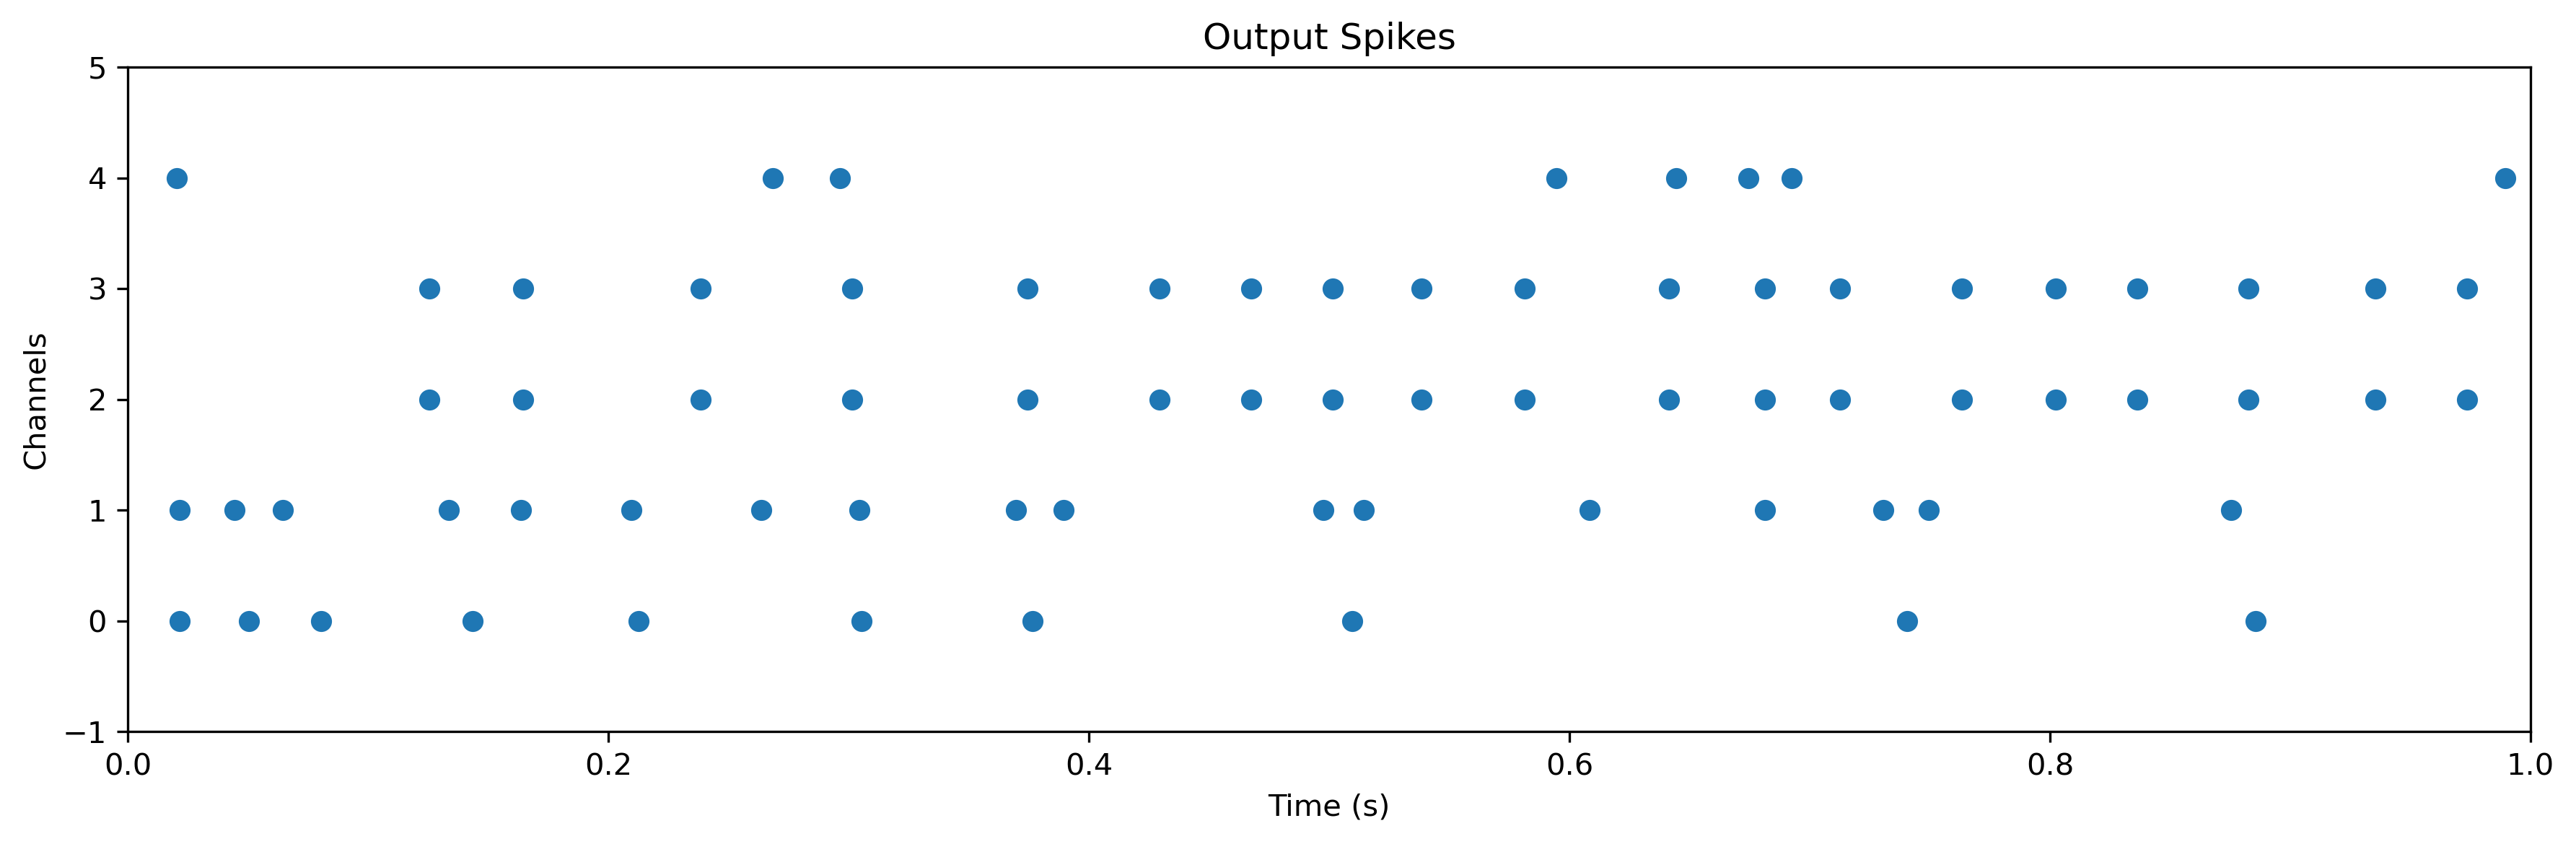

In [35]:
j_out = Figure.plot_spikes(j_out_spikes, name="JIT Output Spikes")
plt.figure()
out = Figure.plot_spikes(out_spikes, name="Output Spikes")
np.testing.assert_array_equal(out.times, j_out.times)

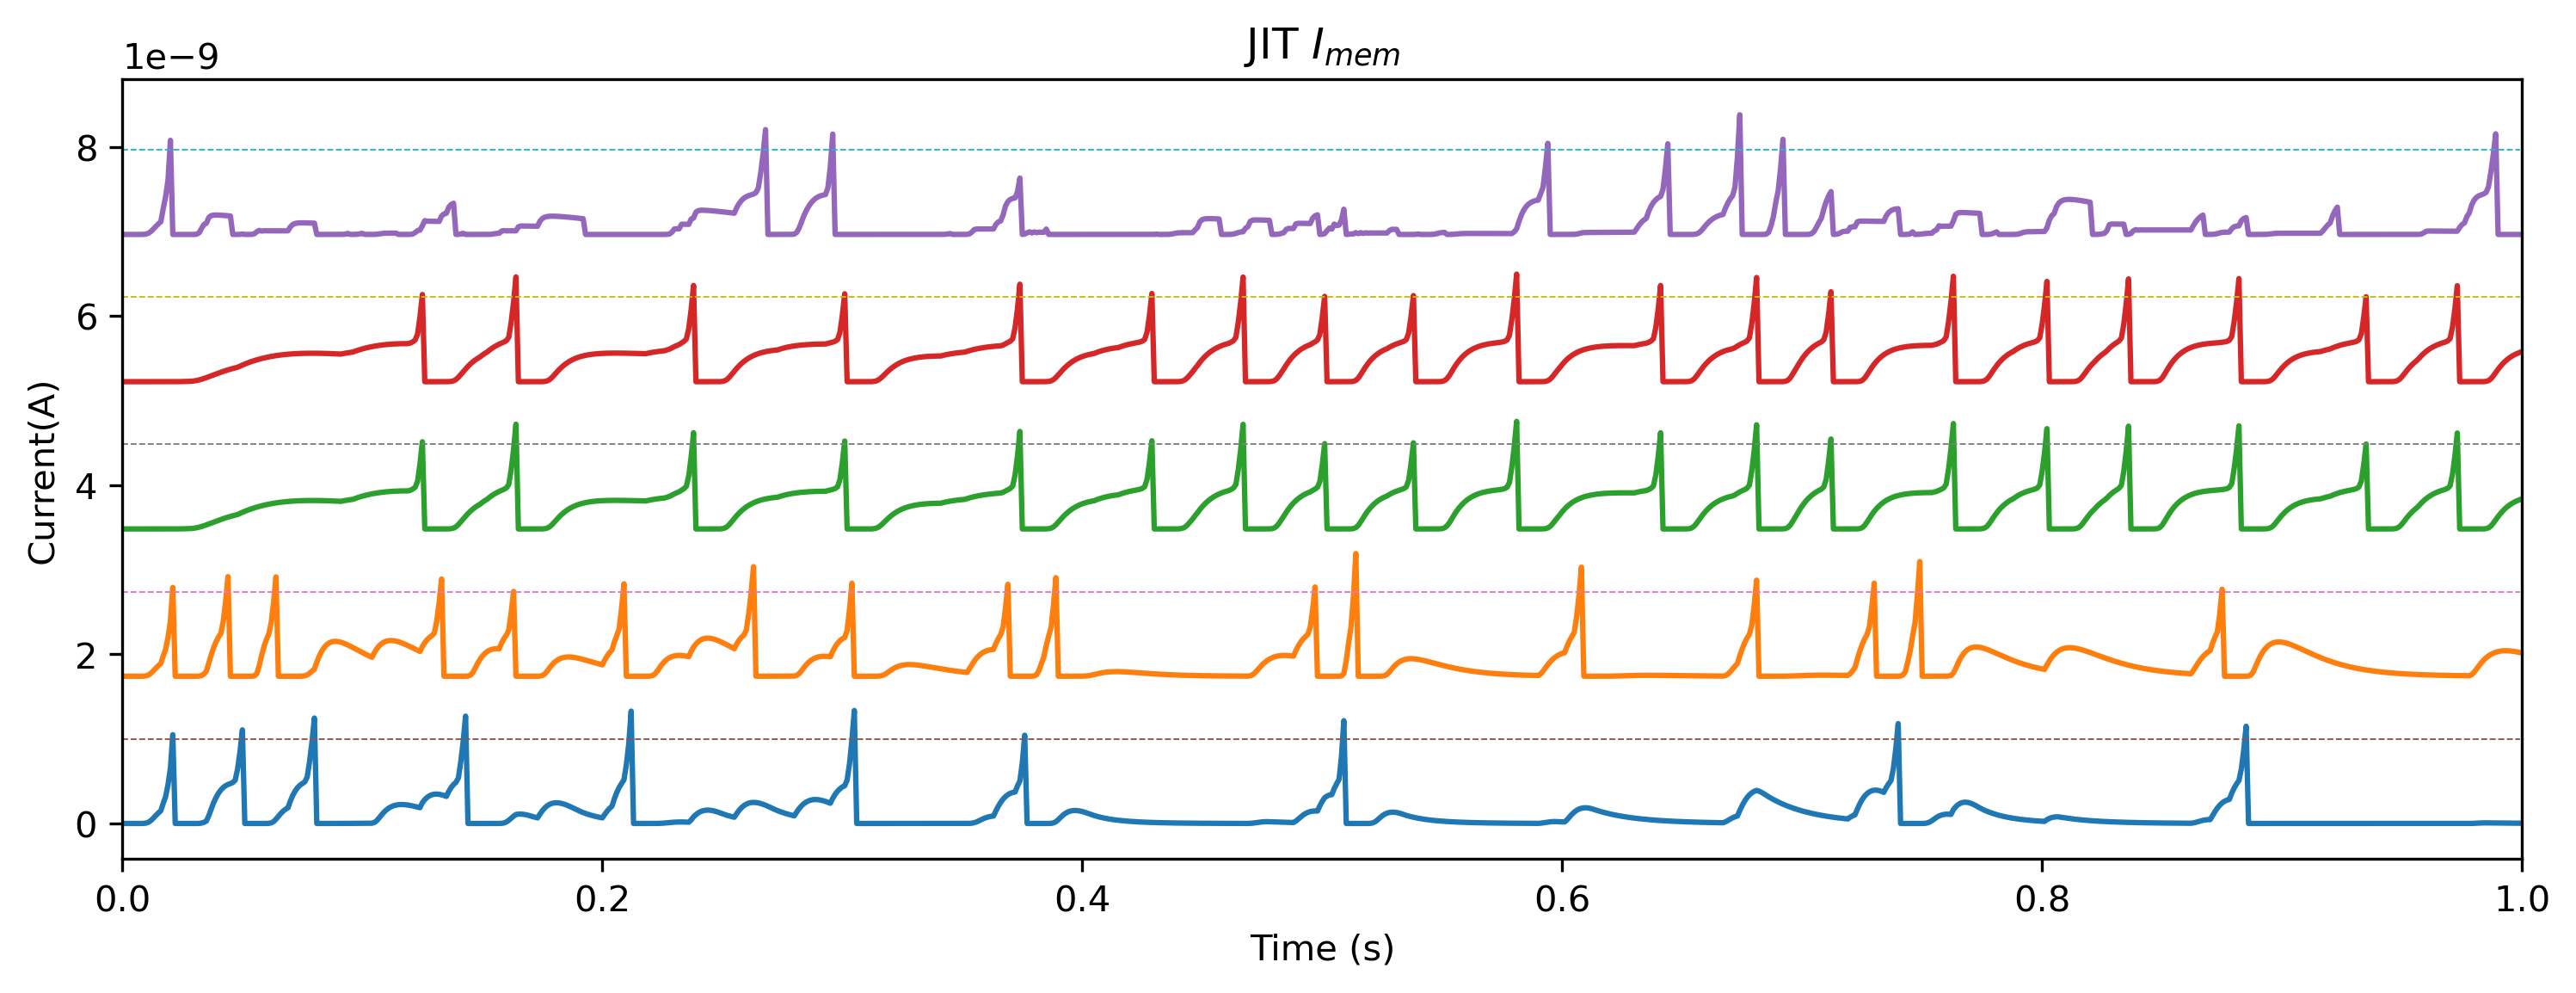

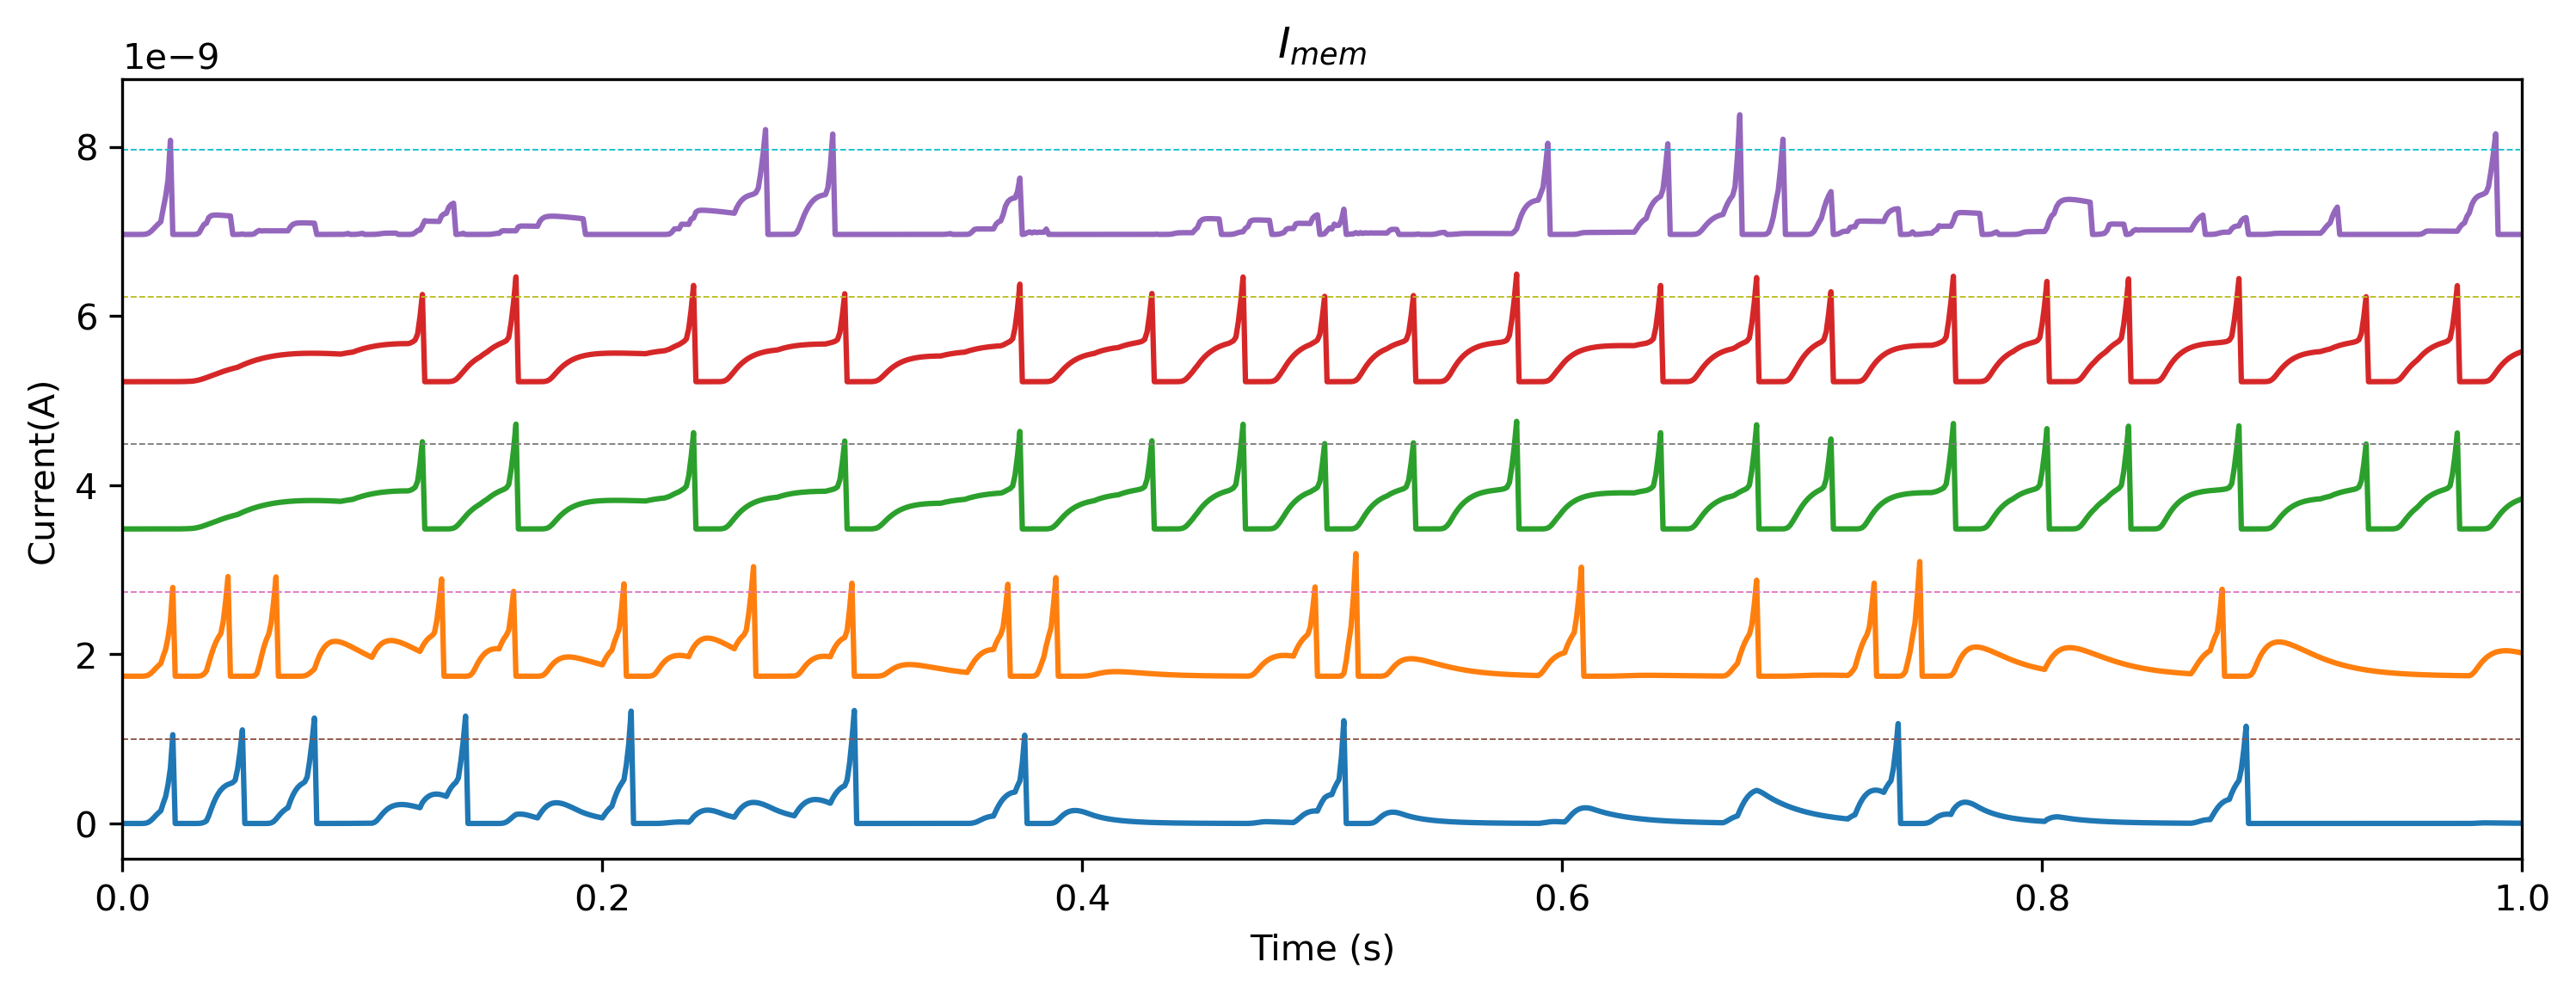

In [36]:
j_Imem, j_Ispk_thr = Figure.plot_Ix(j_record_dict["Imem"], j_modSE.Ispkthr, name="JIT $I_{mem}$")

plt.figure()
Imem, Ispkthr = Figure.plot_Ix(record_dict["Imem"], modSE.Ispkthr, name="$I_{mem}$")
np.testing.assert_array_equal(Imem.times, j_Imem.times)

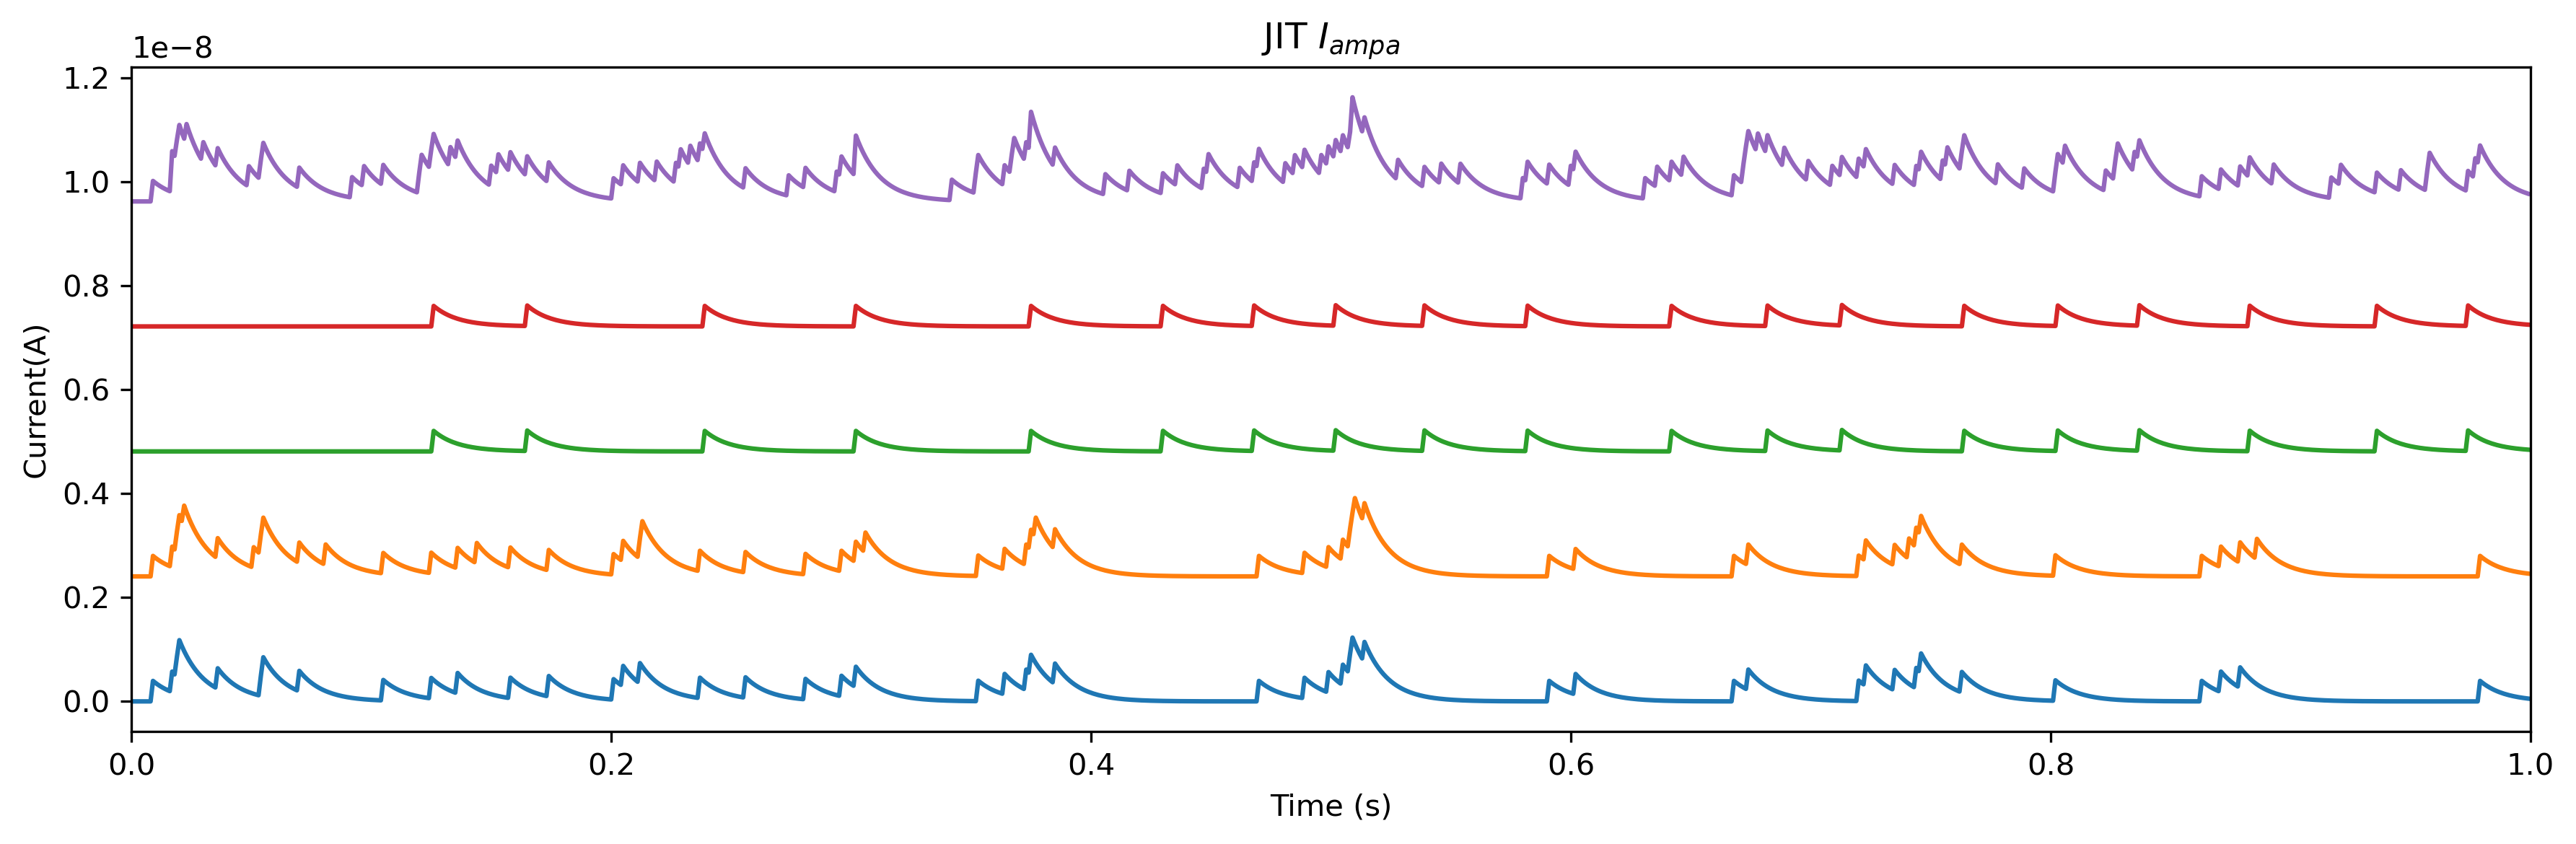

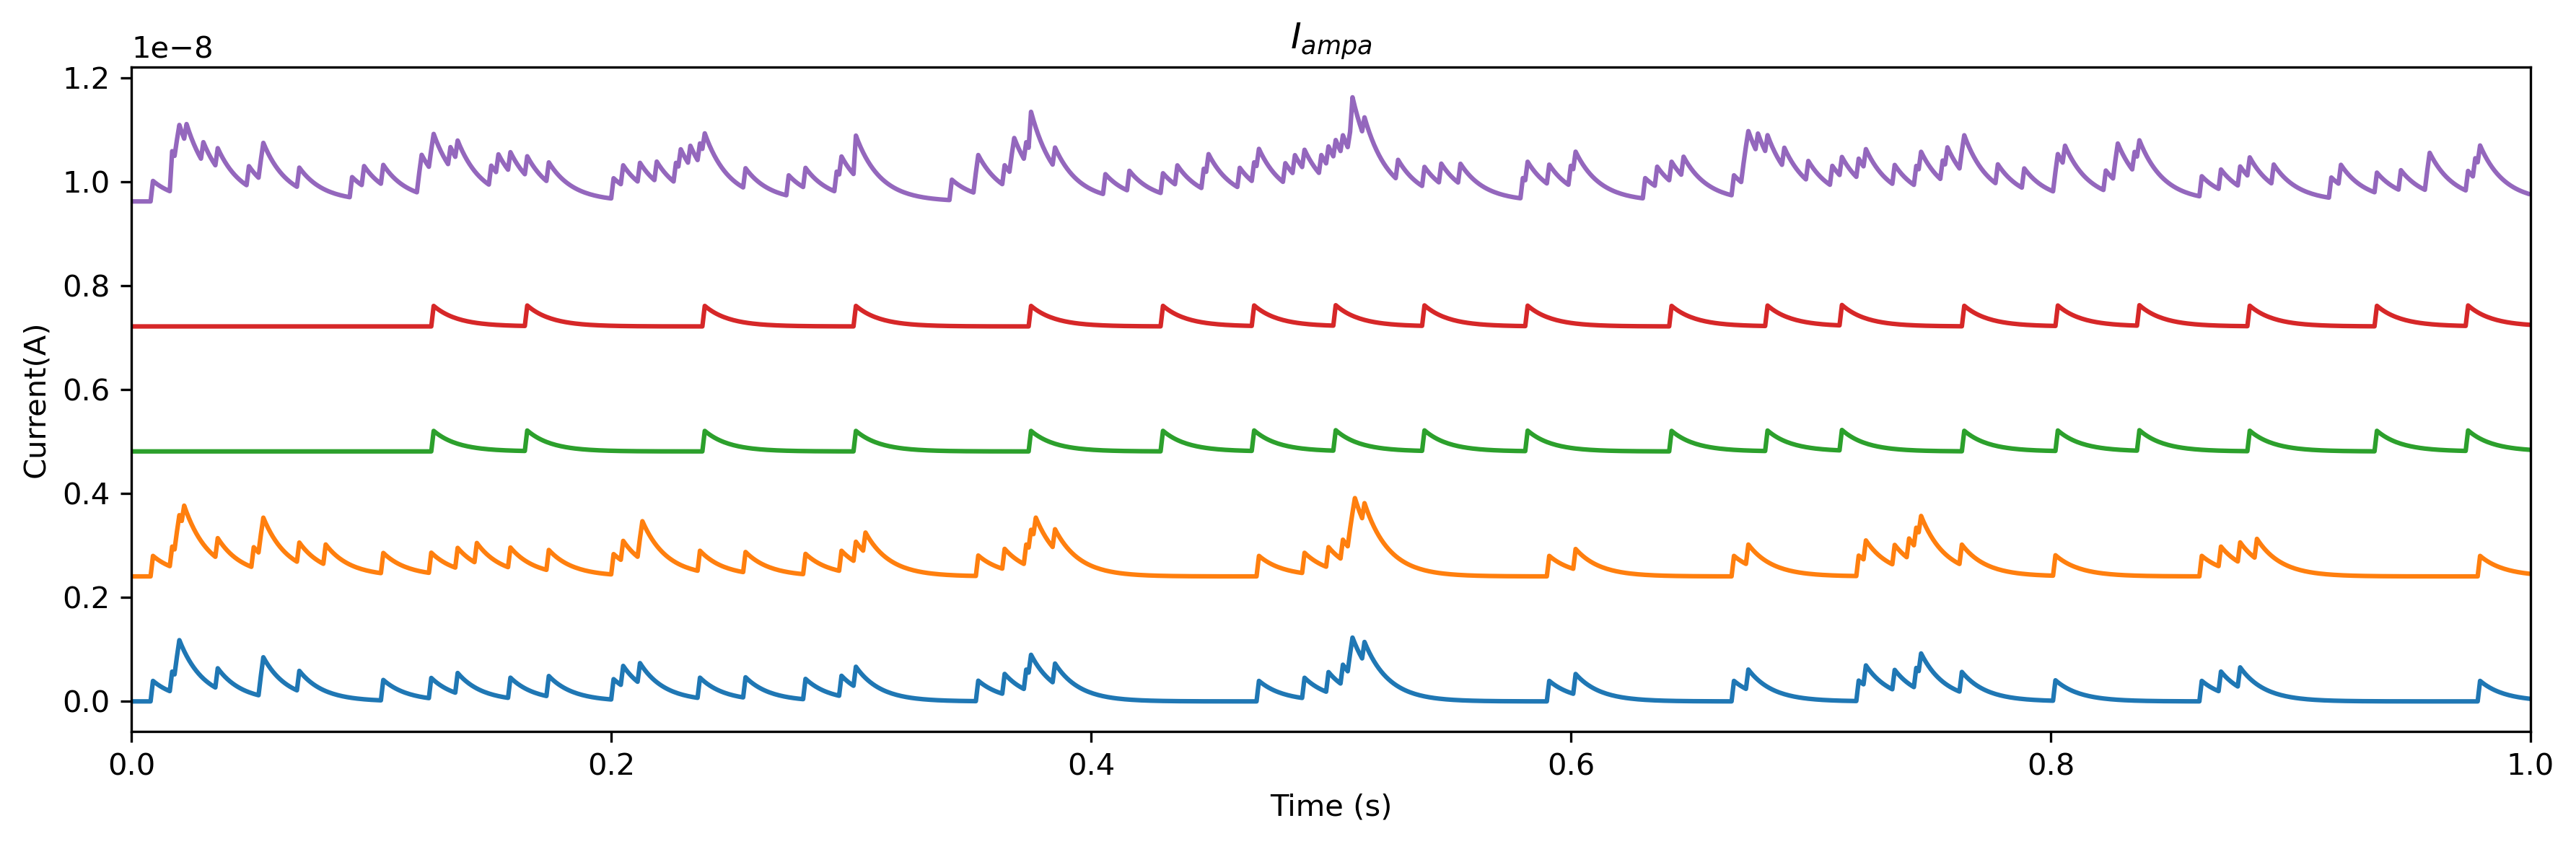

In [37]:
j_Inmda = Figure.plot_Ix(j_record_dict["Iampa"], name="JIT $I_{ampa}$")

plt.figure()
Inmda  = Figure.plot_Ix(record_dict["Iampa"], name="$I_{ampa}$")
np.testing.assert_array_equal(Inmda.times, j_Inmda.times)

In [38]:
def loss(params, mod_orig, input, target):
    mod_new = mod_orig.set_attributes(params)
    
    out, _, r_d = mod_new(input, record = True)
    
    return np.mean((out - target) ** 2)

In [39]:
p = modSE.parameters()
loss(p, modSE, input_ts.raster(dt = dt), 10.)

DeviceArray(99.7226, dtype=float32)

In [40]:
vgf_loss = jax.value_and_grad(loss)

In [41]:
l, g = vgf_loss(p, modSE, input_ts.raster(dt = dt), 10.)

In [42]:
# Should not be all zeros
g

{'Itau_mem': DeviceArray([-8.5115069e-08, -9.5484694e-08, -4.3762086e-07,
              -4.3762086e-07, -1.1880214e-07], dtype=float32),
 'Itau_syn': DeviceArray([[ 1.60040372e-08,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00, -2.50287911e-07],
              [ 0.00000000e+00,  0.00000000e+00, -6.14621811e-08,
               -6.14621811e-08,  7.98161037e-10],
              [-4.09992431e-08,  7.49841167e-09,  1.10965956e-07,
                1.10965956e-07,  1.55824464e-09],
              [-3.85828258e-10, -1.29282558e-08, -6.43928431e-08,
               -6.43928431e-08,  6.12477569e-10]], dtype=float32),
 'Iw': DeviceArray([[ 5.85297002e-12,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  0.00000000e+00],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  6.70806119e-12],
              [ 

In [43]:
a = jax.grad(step_pwl)(1e-8, 1e-9, 5e-13)
b = jax.grad(step_pwl)(1e-10, 1e-9, 5e-13)
c = jax.grad(step_pwl)(1e-13, 1e-9, 5e-13)
print(a)
print(b)
print(c)

9.995e-10
9.995e-10
0.0


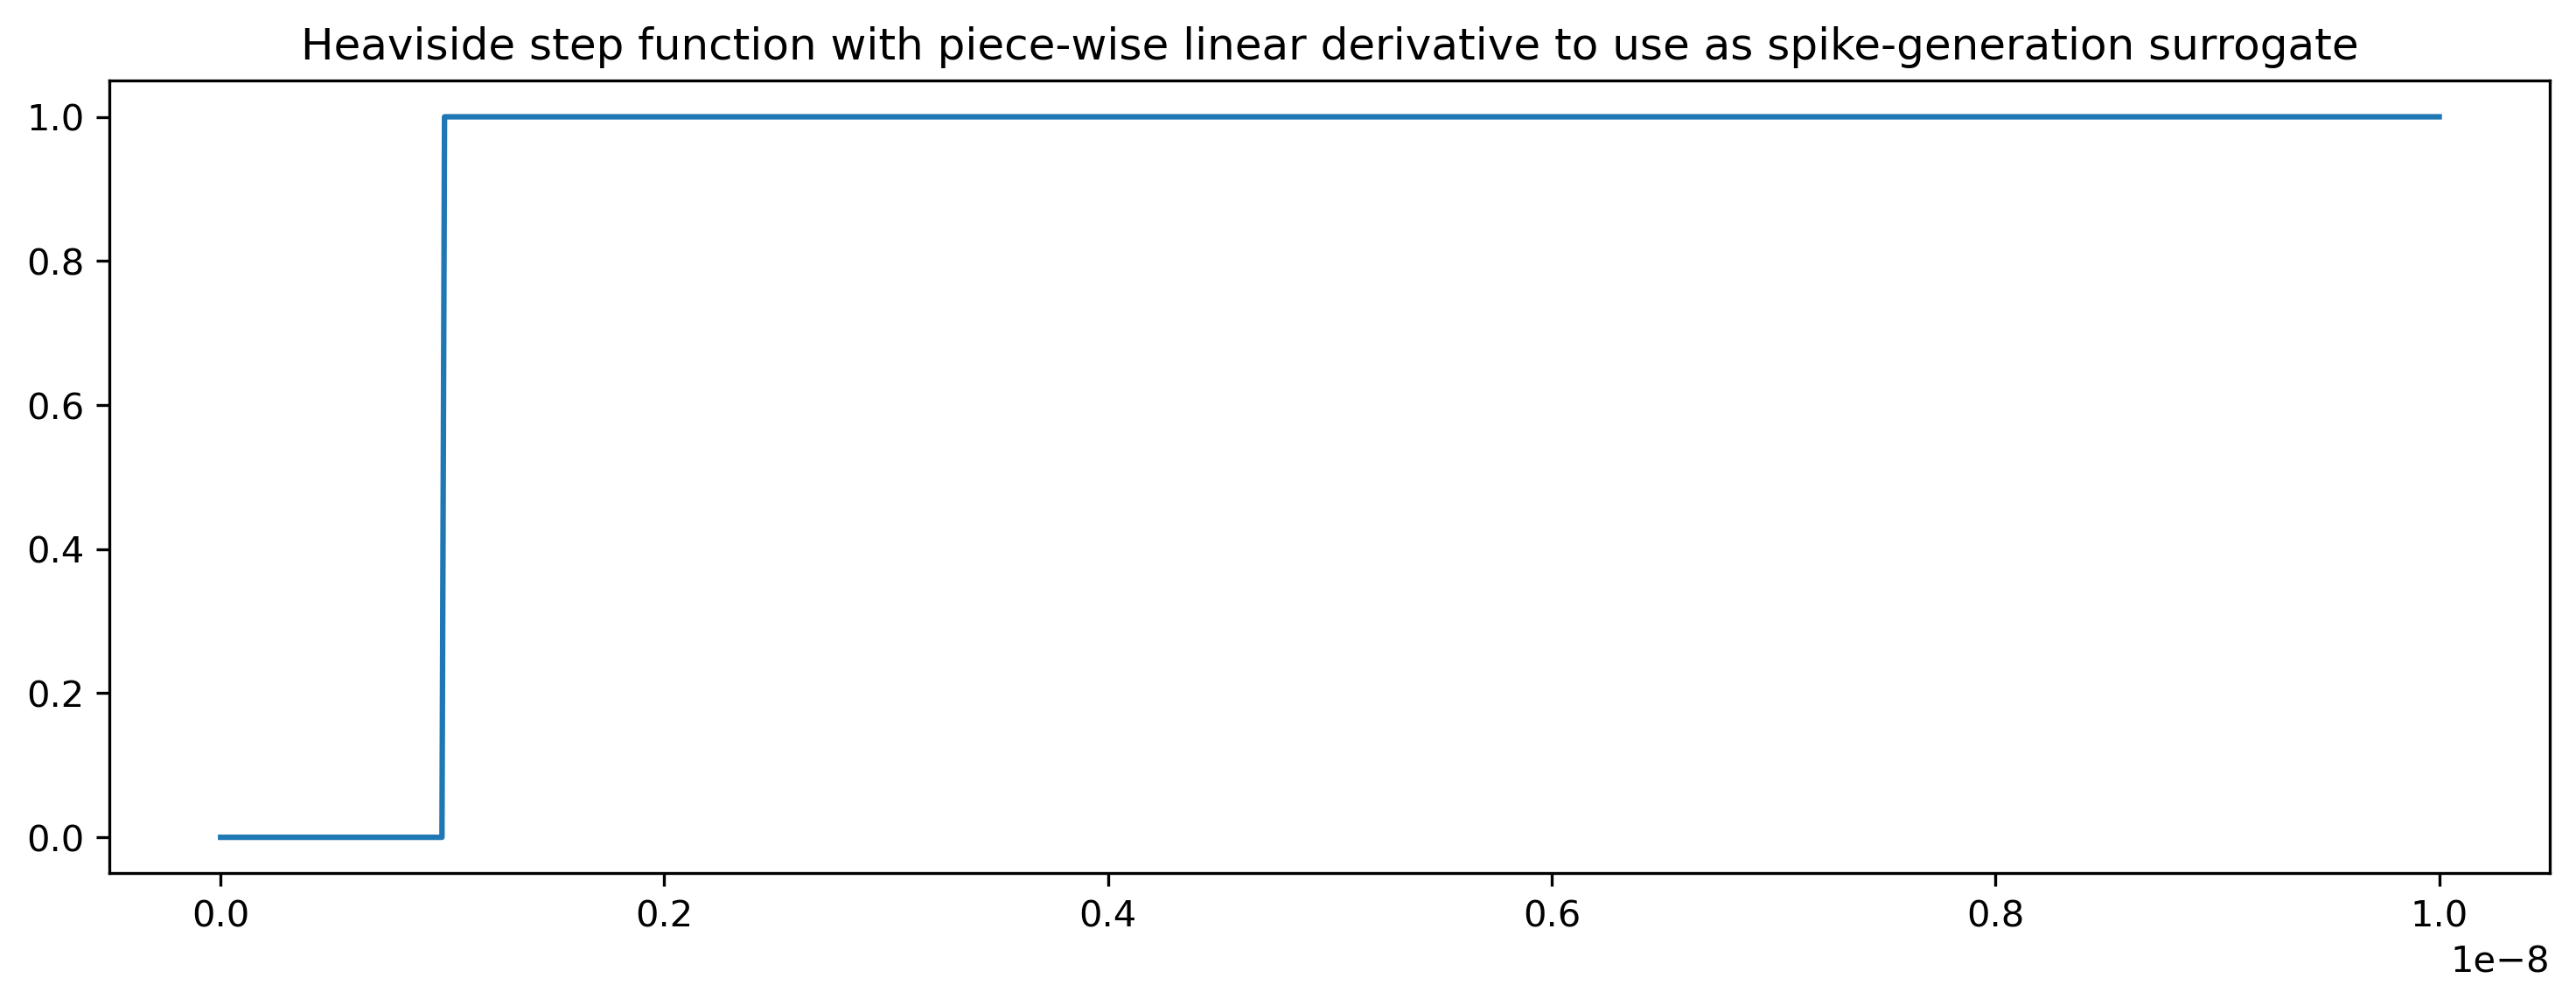

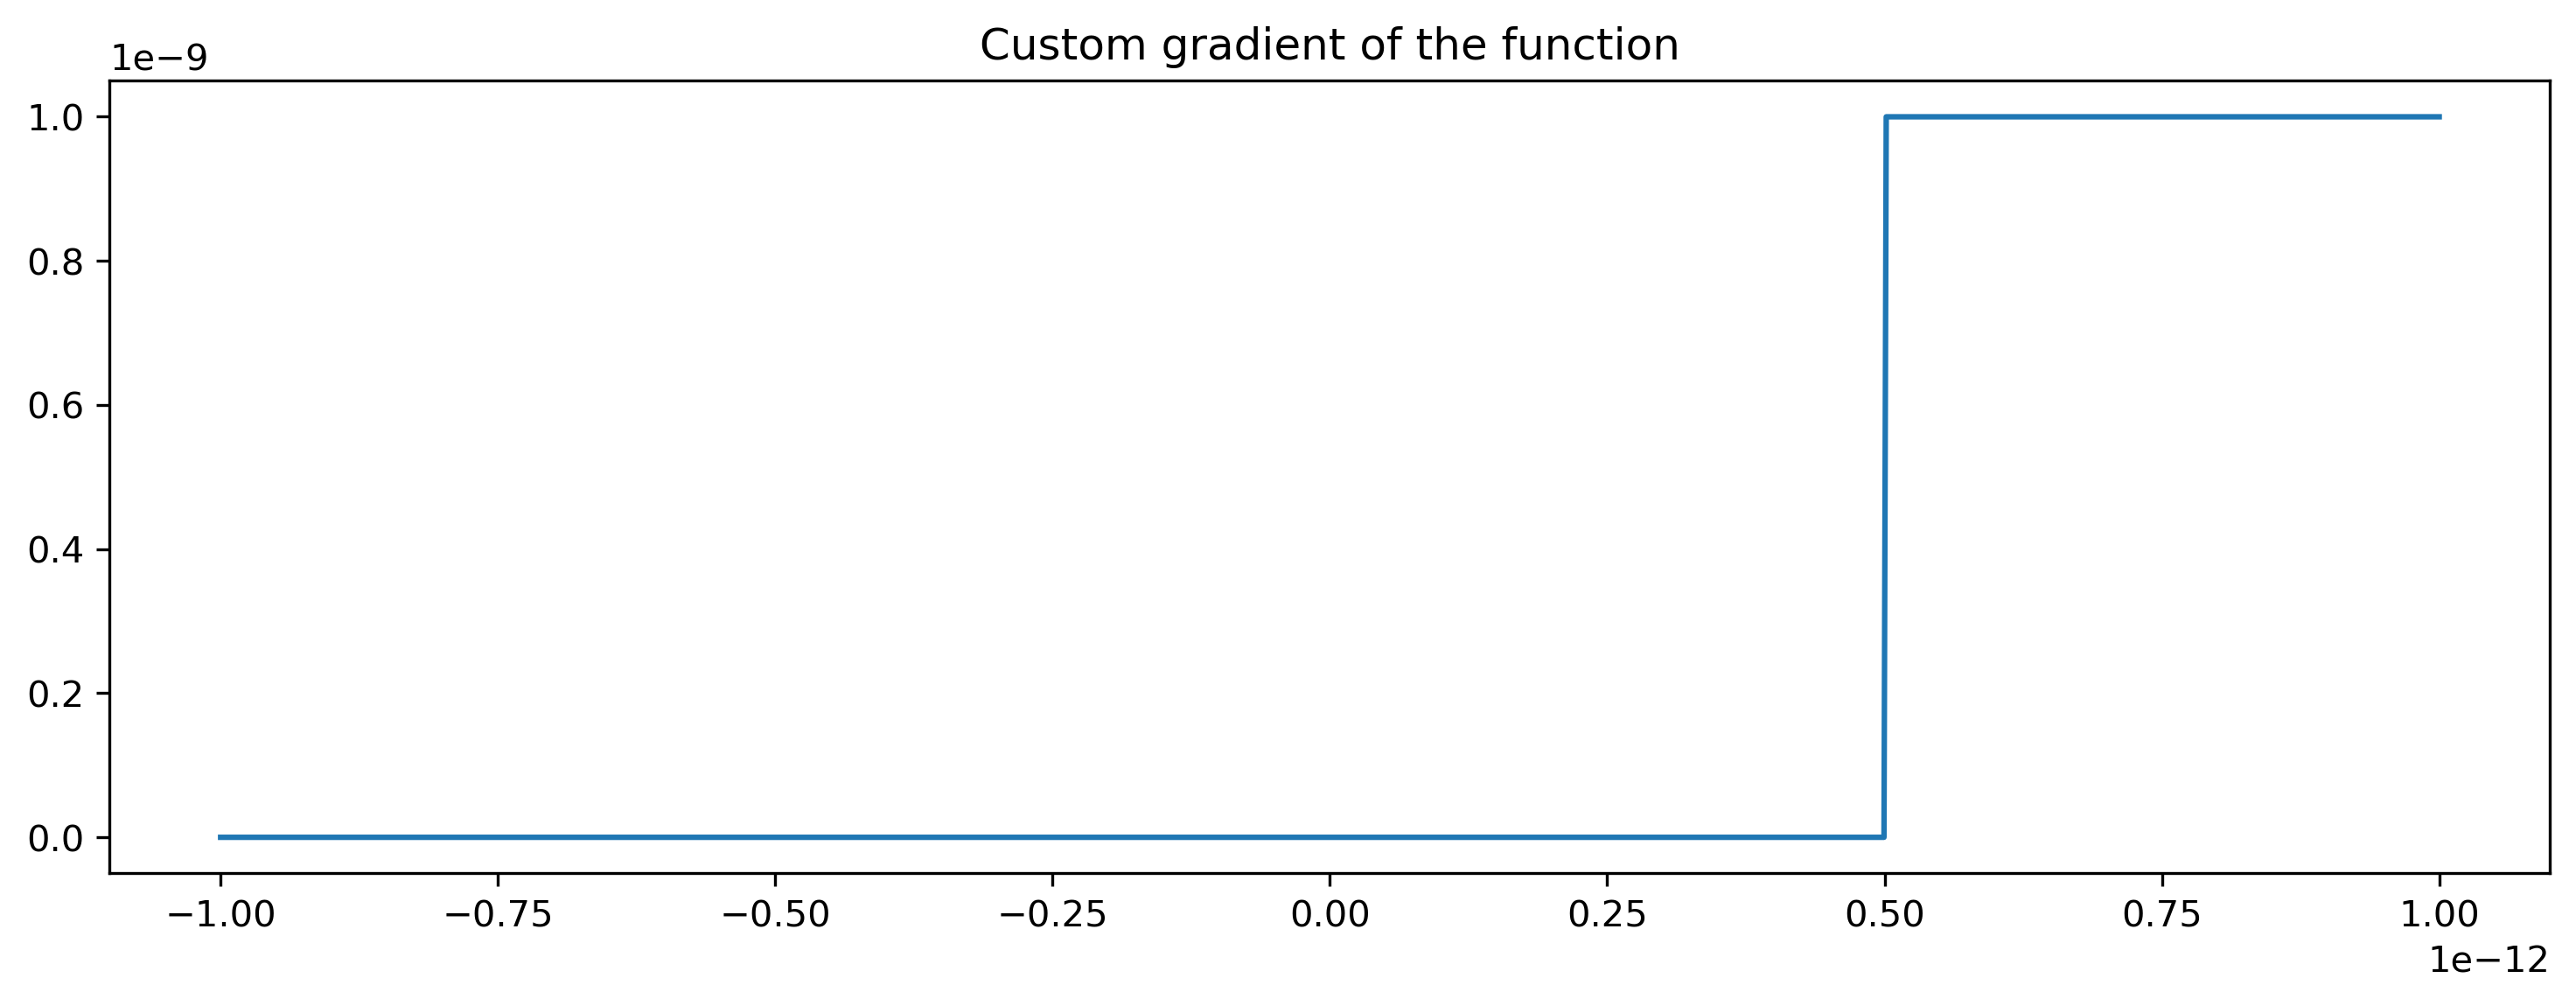

In [44]:
xs_func = jnp.logspace(start=-13, stop=-8, num=1000)
func = [step_pwl(x, modSE.Ispkthr[0], modSE.Ireset[0]) for x in xs_func]

plt.figure()
plt.title("Heaviside step function with piece-wise linear derivative to use as spike-generation surrogate")
plt.plot(xs_func, func)
plt.show()

xs_grad = jnp.linspace(-10e-13, 10e-13, 1000)
grad = [jax.grad(step_pwl)(x, modSE.Ispkthr[0], modSE.Ireset[0]) for x in xs_grad]

plt.figure()
plt.title("Custom gradient of the function")
plt.plot(xs_grad, grad)
plt.show()
